<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Traductor
Ejemplo basado en [LINK](https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/)

### Datos
El objecto es utilizar datos disponibles de Anki de traducciones de texto en diferentes idiomas. Se construirá un modelo traductor seq2seq utilizando encoder-decoder.\
[LINK](https://www.manythings.org/anki/)

In [1]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

cuda = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
# # ------------------------------------------------------------
# # 1)  métrica que ignora <pad>
# # ------------------------------------------------------------
# def sequence_acc(y_pred_logits, y_true_idx, pad_idx=0):
#     """
#     Accuracy token-a-token, excluyendo posiciones <pad>.
#       y_pred_logits : [B, L, V]
#       y_true_idx    : [B, L] con 0 = <pad>
#     """
#     pred_idx = y_pred_logits.argmax(dim=-1)      # [B, L]
#     mask     = (y_true_idx != pad_idx)           # True donde hay palabra
#     correct  = (pred_idx == y_true_idx) & mask

#     total = mask.sum()
#     return (correct.float().sum() / total) if total > 0 else torch.tensor(0.0)


# # ------------------------------------------------------------
# # 2)  función de entrenamiento con <pad> ignorado en loss y acc
# # ------------------------------------------------------------
# def train(model,
#           train_loader,
#           valid_loader,
#           optimizer,
#           criterion,                 # CrossEntropyLoss(ignore_index=0)
#           epochs=100,
#           patience=5,
#           min_delta=1e-4,
#           device='cuda',
#           pad_idx=0):

#     model = model.to(device)

#     train_loss, train_acc = [], []
#     valid_loss, valid_acc = [], []

#     best_val_loss = float('inf')
#     patience_ctr  = 0
#     best_state    = None

#     for epoch in range(1, epochs + 1):
#         # ---------- TRAIN ----------
#         model.train()
#         running_loss, running_acc = 0.0, 0.0

#         for enc_in, dec_in, target_idx in train_loader:
#             enc_in   = enc_in.to(device).long()
#             dec_in   = dec_in.to(device).long()
#             target_idx = target_idx.to(device).long()   # [B, L]

#             optimizer.zero_grad()

#             logits = model(enc_in, dec_in)              # [B, L, V]
#             B, L, V = logits.shape
#             loss = criterion(
#                 logits.view(-1, V),                    # [B*L, V]
#                 target_idx.view(-1)                    # [B*L]
#             )
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()
#             running_acc  += sequence_acc(logits, target_idx, pad_idx).item()

#         avg_train_loss = running_loss / len(train_loader)
#         avg_train_acc  = running_acc  / len(train_loader)
#         train_loss.append(avg_train_loss)
#         train_acc .append(avg_train_acc)

#         # ---------- VALID ----------
#         model.eval()
#         val_loss, val_acc = 0.0, 0.0
#         with torch.no_grad():
#             for enc_in, dec_in, target_idx in valid_loader:
#                 enc_in   = enc_in.to(device).long()
#                 dec_in   = dec_in.to(device).long()
#                 target_idx = target_idx.to(device).long()

#                 logits = model(enc_in, dec_in)
#                 loss   = criterion(
#                     logits.view(-1, V), target_idx.view(-1)
#                 )

#                 val_loss += loss.item()
#                 val_acc  += sequence_acc(logits, target_idx, pad_idx).item()

#         avg_val_loss = val_loss / len(valid_loader)
#         avg_val_acc  = val_acc  / len(valid_loader)
#         valid_loss.append(avg_val_loss)
#         valid_acc .append(avg_val_acc)

#         print(f"Epoch {epoch}/{epochs} — "
#               f"Train Loss {avg_train_loss:.4f} Acc {avg_train_acc:.4f} | "
#               f"Val Loss {avg_val_loss:.4f} Acc {avg_val_acc:.4f}")

#         # ---------- EARLY STOPPING ----------
#         if avg_val_loss + min_delta < best_val_loss:
#             best_val_loss = avg_val_loss
#             patience_ctr  = 0
#             best_state    = model.state_dict()
#         else:
#             patience_ctr += 1
#             if patience_ctr >= patience:
#                 print(f"\nEarly stopping at epoch {epoch}")
#                 break

#     if best_state is not None:
#         model.load_state_dict(best_state)

#     history = {
#         "loss":        train_loss,
#         "accuracy":    train_acc,
#         "val_loss":    valid_loss,
#         "val_accuracy":valid_acc,
#     }
#     return history, model


In [139]:
# ─────────────────────────────────────────────────────────────
# 2) Métrica de accuracy con máscara de padding
# ─────────────────────────────────────────────────────────────
def sequence_acc(logits, tgt_idx, pad_idx=0):
    """
    logits : [B, L, V]  – salida del modelo
    tgt_idx: [B, L]     – índices ground-truth
    """
    pred_idx = logits.argmax(dim=-1)
    mask     = tgt_idx.ne(pad_idx)            # True donde hay palabra
    correct  = (pred_idx.eq(tgt_idx) & mask).float()

    total = mask.sum()
    return correct.sum() / total if total > 0 else torch.tensor(0.0)

# ─────────────────────────────────────────────────────────────
# 3) Función de entrenamiento
# ─────────────────────────────────────────────────────────────
def train(model,
          train_loader,
          valid_loader,
          optimizer,
          criterion,               # CrossEntropyLoss(ignore_index=pad_idx)
          epochs     = 50,
          patience   = 7,
          min_delta  = 1e-4,
          device     = "cuda",
          pad_idx    = 0):

    model.to(device)
    best_val_loss = float("inf")
    wait          = 0
    best_state    = None

    history = {"loss": [], "accuracy": [], "val_loss": [], "val_accuracy": []}

    for epoch in range(1, epochs + 1):
        # ----- TRAIN -----
        model.train()
        tot_loss, tot_acc = 0, 0

        for enc_in, dec_in, tgt_idx in train_loader:
            enc_in   = enc_in.to(device)
            dec_in   = dec_in.to(device)
            tgt_idx  = tgt_idx.to(device)

            optimizer.zero_grad()
            logits = model(enc_in, dec_in)            # [B, L, V]

            B, L, V = logits.shape
            loss = criterion(logits.view(-1, V), tgt_idx.view(-1))
            loss.backward()
            optimizer.step()

            tot_loss += loss.item()
            tot_acc  += sequence_acc(logits, tgt_idx, pad_idx).item()

        train_loss = tot_loss / len(train_loader)
        train_acc  = tot_acc  / len(train_loader)

        # ----- VALID -----
        model.eval()
        val_loss, val_acc = 0, 0
        with torch.no_grad():
            for enc_in, dec_in, tgt_idx in valid_loader:
                enc_in  = enc_in.to(device)
                dec_in  = dec_in.to(device)
                tgt_idx = tgt_idx.to(device)

                logits = model(enc_in, dec_in)
                B, L, V = logits.shape
                loss = criterion(logits.view(-1, V), tgt_idx.view(-1))

                val_loss += loss.item()
                val_acc  += sequence_acc(logits, tgt_idx, pad_idx).item()

        val_loss /= len(valid_loader)
        val_acc  /= len(valid_loader)

        history["loss"].append(train_loss)
        history["accuracy"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)

        print(f"Epoch {epoch:3d}: "
              f"Train L={train_loss:.4f} A={train_acc:.4f} | "
              f"Val L={val_loss:.4f} A={val_acc:.4f}")

        # ----- EARLY STOPPING -----
        if val_loss + min_delta < best_val_loss:
            best_val_loss = val_loss
            best_state    = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return history, model

### 1 - Datos

In [4]:
# dataset_file

text_file = "./clase/spa-eng/spa.txt"
with open(text_file, encoding="utf8") as f:
    lines = f.read().split("\n")[:-1]

# Por limitaciones de RAM no se leen todas las filas
MAX_NUM_SENTENCES = 0

# Mezclar el dataset, forzar semilla siempre igual
np.random.seed([40])
np.random.shuffle(lines)

input_sentences = []
output_sentences = []
output_sentences_inputs = []
count = 0

if MAX_NUM_SENTENCES == 0:
    MAX_NUM_SENTENCES = len(lines)
for line in lines:
    count += 1
    if count > MAX_NUM_SENTENCES:
        break

    if '\t' not in line:
        continue

    # Input sentence --> eng
    # output --> spa
    input_sentence, output = line.rstrip().split('\t')

    # output sentence (decoder_output) tiene <eos>
    output_sentence = output + ' <eos>'
    # output sentence input (decoder_input) tiene <sos>
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows disponibles:", len(lines))
print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows disponibles: 118964
Cantidad de rows utilizadas: 118964


In [5]:
input_sentences[0], output_sentences[0], output_sentences_inputs[0]

('A deal is a deal.',
 'Un trato es un trato. <eos>',
 '<sos> Un trato es un trato.')

### 2 - Preprocesamiento

In [6]:
# Definir el tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 30000

In [7]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.
from clase.torch_helpers import Tokenizer
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 13524
Sentencia de entrada más larga: 47


In [8]:
# A los filtros de símbolos del Tokenizer agregamos el "¿",
# sacamos los "<>" para que no afectar nuestros tokens
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) # Se suma 1 por el primer <sos>
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 26341
Sentencia de salida más larga: 50


Como era de esperarse, las sentencias en castellano son más largas que en inglés, y lo mismo sucede con su vocabulario.

In [9]:
# Por una cuestion de que no explote la RAM se limitará el tamaño de las sentencias de entrada
# a la mitad:
# max_input_len = 20#30#50
# max_out_len = 22#30#54

A la hora de realiza padding es importante teneer en cuenta que en el encoder los ceros se agregan al comienoz y en el decoder al final. Esto es porque la salida del encoder está basado en las últimas palabras de la sentencia (son las más importantes), mientras que en el decoder está basado en el comienzo de la secuencia de salida ya que es la realimentación del sistema y termina con fin de sentencia.

In [10]:
from clase.torch_helpers import pad_sequences
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 118964
encoder_input_sequences shape: (118964, 47)
decoder_input_sequences shape: (118964, 50)


In [11]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences shape:", decoder_output_sequences.shape)

decoder_output_sequences shape: (118964, 50)


La última capa del modelo (softmax) necesita que los valores de salida
del decoder (decoder_sequences) estén en formato oneHotEncoder.\
Se utiliza "decoder_output_sequences" con la misma estrategía que se transformó la entrada del decoder.

In [12]:
torch.from_numpy(decoder_output_sequences).shape

torch.Size([118964, 50])

In [13]:
# class Data(Dataset):
#     def __init__(self, encoder_input, decoder_input, decoder_output):
#         # Convertir los arrays de numpy a tensores. 
#         # pytorch espera en general entradas 32bits
#         self.encoder_inputs = torch.from_numpy(encoder_input.astype(np.int32))
#         self.decoder_inputs = torch.from_numpy(decoder_input.astype(np.int32))
#         # Transformar los datos a oneHotEncoding
#         # la loss function esperan la salida float
#         self.decoder_outputs = F.one_hot(torch.from_numpy(decoder_output).to(torch.int64), num_classes=num_words_output).float()

#         self.len = self.decoder_outputs.shape[0]

#     def __getitem__(self,index):
#         return self.encoder_inputs[index], self.decoder_inputs[index], self.decoder_outputs[index]

#     def __len__(self):
#         return self.len

# data_set = Data(encoder_input_sequences, decoder_input_sequences, decoder_output_sequences)

# encoder_input_size = data_set.encoder_inputs.shape[1]
# print("encoder_input_size:", encoder_input_size)

# decoder_input_size = data_set.decoder_inputs.shape[1]
# print("decoder_input_size:", decoder_input_size)

# output_dim = data_set.decoder_outputs.shape[2]
# print("Output dim", output_dim)

In [14]:
class Seq2SeqDataset(Dataset):
    """
    Devuelve tensores int64 con PAD=0.
    ─ encoder_inputs : [N, T_enc]
    ─ decoder_inputs : [N, T_dec]   (<sos> + frase)
    ─ decoder_outputs: [N, T_dec]   (frase + <eos>)
    """
    def __init__(self, enc_arr: np.ndarray,
                       dec_in_arr: np.ndarray,
                       dec_out_arr: np.ndarray):

        # Convertir a tensores int64
        self.encoder_inputs  = torch.from_numpy(enc_arr    .astype(np.int64))
        self.decoder_inputs  = torch.from_numpy(dec_in_arr .astype(np.int64))
        self.decoder_outputs = torch.from_numpy(dec_out_arr.astype(np.int64))

        assert len(self.encoder_inputs) == len(self.decoder_inputs) == len(self.decoder_outputs), \
            "Los tres arrays deben tener la misma longitud"

    def __getitem__(self, idx):
        return (self.encoder_inputs [idx],
                self.decoder_inputs [idx],
                self.decoder_outputs[idx])

    def __len__(self):
        return len(self.encoder_inputs)
    
# Construcción
data_set = Seq2SeqDataset(encoder_input_sequences,
                          decoder_input_sequences,
                          decoder_output_sequences)

encoder_input_size = data_set.encoder_inputs.shape[1]
print("encoder_input_size:", encoder_input_size)

decoder_input_size = data_set.decoder_inputs.shape[1]
print("decoder_input_size:", decoder_input_size)

output_dim = data_set.decoder_outputs.shape[1]
print("Output dim", output_dim)

encoder_input_size: 47
decoder_input_size: 50
Output dim 50


In [15]:
torch.manual_seed(42)
valid_set_size = int(len(data_set) * 0.2)
train_set_size = len(data_set) - valid_set_size

train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, len(data_set)))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

# train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
# valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=False)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=256, shuffle=True, num_workers=0, pin_memory=True)

Tamaño del conjunto de entrenamiento: 95172
Tamaño del conjunto de validacion: 23792


### 3 - Preparar los embeddings

In [16]:
from gensim.models.fasttext import load_facebook_vectors
model_embeddings = load_facebook_vectors("clase/cc.en.300.bin")  
from gensim.models.fasttext import load_facebook_vectors
model_embeddings_es = load_facebook_vectors("clase/cc.es.300.bin")

In [17]:
vocab_size_in  = max(word2idx_inputs .values()) + 1   
vocab_size_out = max(word2idx_outputs.values()) + 1   
embed_dim = 300
# Inglés
embedding_matrix = np.zeros((vocab_size_in, embed_dim), dtype=np.float32)
for w, idx in word2idx_inputs.items():
    # idx incluye todos los valores hasta max_index
    if w in model_embeddings:
        embedding_matrix[idx] = model_embeddings[w]
# Español
embedding_matrix_es = np.zeros((vocab_size_out, embed_dim), dtype=np.float32)
for w, idx in word2idx_outputs.items():
    if w in model_embeddings_es:
        embedding_matrix_es[idx] = model_embeddings_es[w]
print(embedding_matrix.shape)
print(embedding_matrix_es.shape)
nb_words = embedding_matrix.shape[0]
num_words_output = embedding_matrix_es.shape[0]

(13525, 300)
(26342, 300)


### 4 - Entrenar el modelo

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.lstm_size = 128
        self.num_layers = 2
        self.embedding_dim = embed_dim
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # marcar como layer no entrenable (freeze)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.1) # LSTM layer

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out)
        return (ht, ct)

class Decoder(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        self.lstm_size = 128
        self.num_layers = 2
        self.embedding_dim = embed_dim
        self.output_dim = output_dim

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix_es))
        self.embedding.weight.requires_grad = True  # Opcional: Freezar

        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.1) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=self.output_dim) # Fully connected layer

        # self.softmax = nn.Softmax(dim=1) # normalize in dim 1

    def forward(self, x, prev_state):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        # out = self.softmax(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        out = self.fc1(lstm_output)  # conserva la dimensión de secuencia
        # out = self.softmax(out.squeeze(1))  # quita dimensión de secuencia = 1
        return out, (ht, ct)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, encoder_input, decoder_input):
        batch_size = decoder_input.shape[0]
        decoder_input_len = decoder_input.shape[1]
        vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(batch_size, decoder_input_len, vocab_size, device=encoder_input.device)

        # ultimo hidden state del encoder, primer estado oculto del decoder
        prev_state = self.encoder(encoder_input)
        # En la primera iteracion se toma el primer token de target (<sos>)
        input = decoder_input[:, 0:1]

        for t in range(decoder_input_len):
            input = decoder_input[:, t:t+1]
            output, prev_state = self.decoder(input, prev_state)
            # top1 = output.argmax(1).view(-1, 1)
            top1 = output[:, -1, :].argmax(1).view(-1, 1)
            # guardar cada salida (softmax)
            outputs[:, t, :] = output.squeeze(1)
            # outputs[:, t, :] = output

        return outputs

In [137]:
encoder = Encoder(vocab_size=nb_words)
if cuda: encoder.cuda()
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.cuda()

seq2seq = Seq2Seq(encoder, decoder).to(device)
if cuda: seq2seq.cuda()

# Crear el optimizador la una función de error
# optimizer = torch.optim.Adam(seq2seq.parameters(), lr=0.01)
# 1) Separamos parámetros
emb_params   = list(decoder.embedding.parameters())            # solo embedding ES
other_params = [p for n, p in seq2seq.named_parameters()
                if "decoder.embedding" not in n]               # resto de la red

# 2) AdamW con parameter-groups
lr = 0.02
optimizer = torch.optim.AdamW(
    [
        {"params": emb_params,   "lr": lr*0.1},   # LR pequeño para embedding
        {"params": other_params, "lr": lr},   # LR normal resto
    ],
    betas=(0.9, 0.98),
    weight_decay=1e-3
)

criterion = torch.nn.CrossEntropyLoss(ignore_index=0)  # Omito el padding para que no falsee la metrica

x_enc = data_set[0:1][0]
x_dec = data_set[0:1][1]
summary(seq2seq,
        input_data=(x_enc.to(device).long(), x_dec.to(device).long()),
        device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Seq2Seq                                  [1, 50, 26342]            --
├─Encoder: 1-1                           [2, 1, 128]               --
│    └─Embedding: 2-1                    [1, 47, 300]              (4,057,500)
│    └─LSTM: 2-2                         [1, 47, 128]              352,256
├─Decoder: 1-2                           [1, 1, 26342]             --
│    └─Embedding: 2-3                    [1, 1, 300]               7,902,600
│    └─LSTM: 2-4                         [1, 1, 128]               352,256
│    └─Linear: 2-5                       [1, 1, 26342]             3,398,118
├─Decoder: 1-3                           [1, 1, 26342]             (recursive)
│    └─Embedding: 2-6                    [1, 1, 300]               (recursive)
│    └─LSTM: 2-7                         [1, 1, 128]               (recursive)
│    └─Linear: 2-8                       [1, 1, 26342]             (recursive)
├─Decoder: 1-4  

In [140]:
history1, model = train(seq2seq,
                train_loader,
                valid_loader,
                optimizer,
                criterion,
                epochs=100,
                device=device,
                patience=10
                )

Epoch   1: Train L=6.2033 A=0.1779 | Val L=5.7144 A=0.1995
Epoch   2: Train L=5.2496 A=0.2163 | Val L=4.9122 A=0.2481
Epoch   3: Train L=4.3242 A=0.2918 | Val L=4.1632 A=0.3234
Epoch   4: Train L=3.7008 A=0.3478 | Val L=3.8181 A=0.3664
Epoch   5: Train L=3.2961 A=0.3854 | Val L=3.6525 A=0.3906
Epoch   6: Train L=3.0076 A=0.4145 | Val L=3.5323 A=0.4099
Epoch   7: Train L=2.7864 A=0.4384 | Val L=3.4545 A=0.4264
Epoch   8: Train L=2.6082 A=0.4587 | Val L=3.4089 A=0.4375
Epoch   9: Train L=2.4689 A=0.4758 | Val L=3.3868 A=0.4475
Epoch  10: Train L=2.3569 A=0.4898 | Val L=3.3991 A=0.4493
Epoch  11: Train L=2.2644 A=0.5029 | Val L=3.3795 A=0.4573
Epoch  12: Train L=2.1928 A=0.5130 | Val L=3.3780 A=0.4583
Epoch  13: Train L=2.1235 A=0.5238 | Val L=3.4021 A=0.4613
Epoch  14: Train L=2.0659 A=0.5327 | Val L=3.3886 A=0.4676
Epoch  15: Train L=2.0163 A=0.5407 | Val L=3.4090 A=0.4669
Epoch  16: Train L=1.9841 A=0.5465 | Val L=3.4239 A=0.4728
Epoch  17: Train L=1.9444 A=0.5530 | Val L=3.4333 A=0.47

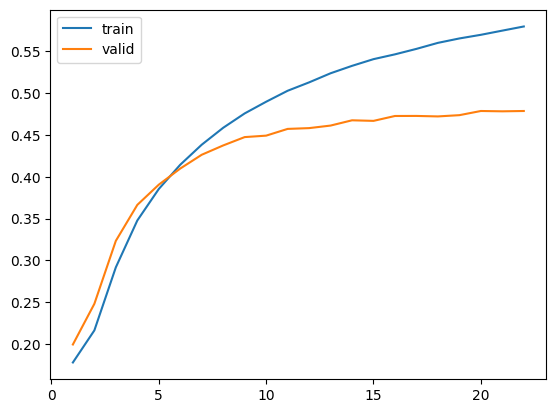

In [141]:
epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history1['val_accuracy'], label='valid')
plt.show()

### 5 - Inferencia

In [142]:
'''
Step 1:
A deal is a deal -> Encoder -> enc(h1,c1)

enc(h1,c1) + <sos> -> Decoder -> Un + dec(h1,c1)

step 2:
dec(h1,c1) + Un -> Decoder -> trato + dec(h2,c2)

step 3:
dec(h2,c2) + trato -> Decoder -> es + dec(h3,c3)

step 4:
dec(h3,c3) + es -> Decoder -> un + dec(h4,c4)

step 5:
dec(h4,c4) + un -> Decoder -> trato + dec(h5,c5)

step 6:
dec(h5,c5) + trato. -> Decoder -> <eos> + dec(h6,c6)
'''

'\nStep 1:\nA deal is a deal -> Encoder -> enc(h1,c1)\n\nenc(h1,c1) + <sos> -> Decoder -> Un + dec(h1,c1)\n\nstep 2:\ndec(h1,c1) + Un -> Decoder -> trato + dec(h2,c2)\n\nstep 3:\ndec(h2,c2) + trato -> Decoder -> es + dec(h3,c3)\n\nstep 4:\ndec(h3,c3) + es -> Decoder -> un + dec(h4,c4)\n\nstep 5:\ndec(h4,c4) + un -> Decoder -> trato + dec(h5,c5)\n\nstep 6:\ndec(h5,c5) + trato. -> Decoder -> <eos> + dec(h6,c6)\n'

In [147]:
# Armar lo conversores de indice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [148]:
def translate_sentence(input_text, 
                       model, 
                       input_tokenizer, 
                       word2idx_outputs, 
                       idx2word_target,
                       max_input_len,
                       max_output_len,
                       device):
    model.eval()
    
    # 1) Tokenizar y paddear
    seq = input_tokenizer.texts_to_sequences([input_text.lower()])[0]
    seq = pad_sequences([seq], maxlen=max_input_len, padding='post')
    
    encoder_input = torch.tensor(seq, dtype=torch.long).to(device)      # [1, max_input_len]
    # 2) Pasar por el encoder
    prev_state = model.encoder(encoder_input)                           # (h, c)
    
    # 3) Iniciar decoder con <sos>
    sos = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    decoder_input = torch.tensor([[sos]], dtype=torch.long).to(device)  # [1, 1]
    
    output_words = []
    # 4) Loop hasta max_output_len o hasta <eos>
    for _ in range(max_output_len):
        logits, prev_state = model.decoder(decoder_input, prev_state)
        # logits: [1, 1, vocab_size]
        
        logits = logits.squeeze(1)           # [1, vocab_size]
        topi = logits.argmax(dim=1)          # [1]
        idx = topi.item()                    # entero
        
        if idx == eos:
            break
        output_words.append(idx2word_target[idx])
        
        # re-alimentar al decoder
        decoder_input = topi.unsqueeze(1)    # [1, 1]
    
    return ' '.join(output_words)



In [149]:
input_test = "My mother say hi."
translation = translate_sentence(
    input_text=input_test,
    model=model,
    input_tokenizer=input_tokenizer,
    word2idx_outputs=word2idx_outputs,
    idx2word_target=idx2word_target,
    max_input_len=max_input_len,
    max_output_len=max_out_len,  
    device=device
)

print("Input:   ", input_test)
print("Output:  ", translation)

Input:    My mother say hi.
Output:   él decidió hilo dental a la velocidad de tom y olviden que visitara boston


In [176]:
i = np.random.choice(len(input_sentences))
input_test = input_sentences[i:i+1][0]
translation = translate_sentence(
    input_text=input_test,
    model=model,
    input_tokenizer=input_tokenizer,
    word2idx_outputs=word2idx_outputs,
    idx2word_target=idx2word_target,
    max_input_len=max_input_len,
    max_output_len=max_out_len,   
    device=device
)

print("Input:   ", input_test)
print("Output:  ", translation)

Input:    This movie is politically incorrect.
Output:   espero que tom gane el concierto antes de que se le ocurra matar a un canadiense


In [177]:
import torch
import math
from copy import deepcopy

def translate_beam_search(
    input_text: str,
    model: Seq2Seq,
    input_tokenizer,
    word2idx_outputs: dict,
    idx2word_target: dict,
    max_input_len: int,
    max_output_len: int,
    device: torch.device,
    beam_width: int = 3,
):

    model.eval()

    # 1) Prepara encoder input
    seq = input_tokenizer.texts_to_sequences([input_text.lower()])[0]
    seq = pad_sequences([seq], maxlen=max_input_len, padding='post')
    encoder_input = torch.tensor(seq, dtype=torch.long).to(device)
    prev_state = model.encoder(encoder_input)  # (h, c)

    sos = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']

    # Cada hipótesis es (tokens: List[int], state, score: float)
    hypotheses = [([sos], prev_state, 0.0)]

    for _ in range(max_output_len):
        all_candidates = []

        # Extender cada hipótesis
        for tokens, state, score in hypotheses:
            last_token = torch.tensor([[tokens[-1]]], dtype=torch.long).to(device)
            logits, new_state = model.decoder(last_token, state)  # [1,1,V]
            log_probs = torch.log_softmax(logits.squeeze(1), dim=-1)  # [1, V]
            topk_logps, topk_idxs = log_probs.topk(beam_width, dim=-1)

            for logp, idx in zip(topk_logps[0], topk_idxs[0]):
                new_tokens = tokens + [idx.item()]
                new_score  = score + logp.item()
                all_candidates.append((new_tokens, new_state, new_score))

        # Ordenar y quedarnos con beam_width mejores
        ordered = sorted(all_candidates, key=lambda tup: tup[2], reverse=True)
        hypotheses = ordered[:beam_width]

        # Si todas terminan en <eos>, interrumpir
        if all(h[0][-1] == eos for h in hypotheses):
            break

    # Elegir la hipótesis con mayor score que termine en <eos> (o la mejor si ninguna termina)
    best = None
    for tokens, state, score in hypotheses:
        if tokens[-1] == eos:
            best = (tokens, score)
            break
    if best is None:
        best = (hypotheses[0][0], hypotheses[0][2])

    # Convertir ids a palabras, quitando <sos> y todo lo que venga tras <eos>
    best_tokens = best[0]
    words = []
    for idx in best_tokens:
        if idx == sos:
            continue
        if idx == eos:
            break
        words.append(idx2word_target.get(idx, '<unk>'))

    return ' '.join(words)


In [180]:
i = np.random.choice(len(input_sentences))
input_test = input_sentences[i:i+1][0]
translation = translate_beam_search(
    input_text=input_test,
    model=model,
    input_tokenizer=input_tokenizer,
    word2idx_outputs=word2idx_outputs,
    idx2word_target=idx2word_target,
    max_input_len=max_input_len,
    max_output_len=max_out_len,
    device=device,
    beam_width=5  
)
print("Input: ", input_test)
print("Output:", translation)


Input:  The ruling party is running a smear campaign against the opposition.
Output: él utilizó hilo dental a la velocidad de la velocidad de tom y olviden que visitara boston


In [29]:
checkpoint = {
    "epoch": len(history1['accuracy']),                  
    "model_state":  model.state_dict(),
    "optimizer_state": optimizer.state_dict()
}
torch.save(checkpoint, "model_checkpoint.pkl")   

In [181]:
import math, random, numpy as np, torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# ─────────────────────────────────────────────
# 1) Dataset + collate
# ─────────────────────────────────────────────
PAD_IDX = 0          # asegurate de que coincide con tu vocabulario
SOS_IDX = 1
EOS_IDX = 2

class Seq2SeqDataset(Dataset):
    """
    Devuelve tensores int64 con PAD=0.
      encoder_inputs : [N, T_enc]
      decoder_inputs : [N, T_dec]  (<sos> + frase)
      decoder_outputs: [N, T_dec]  (frase + <eos>)
    """
    def __init__(self, enc_arr, dec_in_arr, dec_out_arr):
        self.encoder_inputs  = torch.as_tensor(enc_arr,    dtype=torch.long)
        self.decoder_inputs  = torch.as_tensor(dec_in_arr, dtype=torch.long)
        self.decoder_outputs = torch.as_tensor(dec_out_arr,dtype=torch.long)

    def __len__(self):
        return len(self.encoder_inputs)

    def __getitem__(self, idx):
        return (self.encoder_inputs[idx],
                self.decoder_inputs[idx],
                self.decoder_outputs[idx])

def collate_fn(batch):
    """
    Devuelve:
      enc_in  : [B, T_enc]  (padded)
      dec_in  : [B, T_dec]
      tgt_idx : [B, T_dec]
      enc_len : [B]         (longitudes reales sin PAD)
    """
    encs, dins, douts = zip(*batch)
    encs  = torch.stack(encs)
    dins  = torch.stack(dins)
    douts = torch.stack(douts)
    # longitudes reales (≠ PAD)
    enc_len = encs.ne(PAD_IDX).sum(dim=1)
    return encs, dins, douts, enc_len

# ─────────────────────────────────────────────
# 2) Modelo
# ─────────────────────────────────────────────
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, lstm_size=128, n_layers=2,
                 embedding_matrix=None, freeze_emb=True, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = not freeze_emb
        self.lstm = nn.LSTM(embed_dim, lstm_size, n_layers,
                            batch_first=True, dropout=dropout)

    def forward(self, x, lengths):
        # x:[B,T], lengths:[B]
        emb = self.embedding(x)
        packed = pack_padded_sequence(emb, lengths.cpu(),
                                      batch_first=True, enforce_sorted=False)
        _, (h, c) = self.lstm(packed)
        return (h, c)

class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, lstm_size=128, n_layers=2,
                 embedding_matrix=None, freeze_emb=False, dropout=0.1):
        super().__init__()
        self.output_dim = vocab_size
        self.embedding  = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = not freeze_emb
        self.lstm = nn.LSTM(embed_dim, lstm_size, n_layers,
                            batch_first=True, dropout=dropout)
        self.fc   = nn.Linear(lstm_size, vocab_size)

    def forward(self, inp, state):        # inp:[B,1]
        emb = self.embedding(inp)         # [B,1,E]
        out, state = self.lstm(emb, state)# out:[B,1,H]
        logits = self.fc(out)             # [B,1,V]
        return logits, state

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, teacher_forcing_ratio=1.0):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.tfr = teacher_forcing_ratio

    def forward(self, enc_in, dec_in, enc_len):
        B, T_dec = dec_in.shape
        V = self.decoder.output_dim
        device = enc_in.device

        outputs = torch.zeros(B, T_dec, V, device=device)

        state = self.encoder(enc_in, enc_len)
        inp   = dec_in[:, :1]                         # <sos>

        for t in range(T_dec):
            logits, state = self.decoder(inp, state) # logits:[B,1,V]
            outputs[:, t, :] = logits.squeeze(1)

            # decide próximo input
            teacher = torch.rand(1, device=device) < self.tfr
            top1 = logits.squeeze(1).argmax(1, keepdim=True) # [B,1]
            if t+1 < T_dec:
                inp = dec_in[:, t+1:t+2] if teacher else top1
            else:
                inp = top1

        return outputs

# ─────────────────────────────────────────────
# 3) Función de entrenamiento
# ─────────────────────────────────────────────
def sequence_acc(logits, tgt_idx, pad_idx=PAD_IDX):
    pred_idx = logits.argmax(dim=-1)
    mask = tgt_idx.ne(pad_idx)
    correct = (pred_idx.eq(tgt_idx) & mask).float()
    total = mask.sum()
    return correct.sum() / total if total > 0 else torch.tensor(0.0)

def fit(model, train_loader, valid_loader, optimizer, criterion,
        epochs=50, patience=7, min_delta=1e-4,
        clip_norm=1.0, device="cuda", pad_idx=PAD_IDX,
        tfr_scheduler=None):
    model.to(device)
    best_loss, wait, best_state = float('inf'), 0, None
    history = {"loss":[], "accuracy":[], "val_loss":[], "val_accuracy":[]}

    for epoch in range(1, epochs+1):
        # ---- TRAIN ----
        model.train(); tr_loss=tr_acc=0
        for enc_in, dec_in, tgt_idx, enc_len in train_loader:
            enc_in, dec_in, tgt_idx = enc_in.to(device), dec_in.to(device), tgt_idx.to(device)
            enc_len = enc_len.to(device)

            optimizer.zero_grad()
            logits = model(enc_in, dec_in, enc_len)        # [B,T,V]
            B,T,V = logits.shape
            loss = criterion(logits.reshape(-1,V), tgt_idx.reshape(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
            optimizer.step()

            tr_loss += loss.item()
            tr_acc  += sequence_acc(logits, tgt_idx, pad_idx).item()

        tr_loss /= len(train_loader); tr_acc /= len(train_loader)

        # ---- VALID ----
        model.eval(); val_loss=val_acc=0
        with torch.no_grad():
            for enc_in, dec_in, tgt_idx, enc_len in valid_loader:
                enc_in, dec_in, tgt_idx = enc_in.to(device), dec_in.to(device), tgt_idx.to(device)
                enc_len = enc_len.to(device)
                logits = model(enc_in, dec_in, enc_len)
                B,T,V = logits.shape
                loss = criterion(logits.reshape(-1,V), tgt_idx.reshape(-1))

                val_loss += loss.item()
                val_acc  += sequence_acc(logits, tgt_idx, pad_idx).item()

        val_loss /= len(valid_loader); val_acc /= len(valid_loader)

        history["loss"].append(tr_loss)
        history["accuracy"].append(tr_acc)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_acc)

        print(f"Epoch {epoch:3d}: "
              f"Train L={tr_loss:.4f} A={tr_acc:.4f} | "
              f"Val L={val_loss:.4f} A={val_acc:.4f}")

        # early stopping
        if val_loss + min_delta < best_loss:
            best_loss, best_state, wait = val_loss, model.state_dict(), 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping")
                break

        # teacher-forcing scheduler
        if tfr_scheduler is not None:
            model.tfr = tfr_scheduler(epoch, model.tfr)

    if best_state is not None:
        model.load_state_dict(best_state)
    return history, model


In [ ]:
# ─────────────────────────────────────────────
# 4) Ejemplo de armado y lanzamiento
# ─────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"

# → Definí tus arrays  encoder_input_sequences, decoder_input_sequences, decoder_output_sequences
# ...

train_ds = Seq2SeqDataset(encoder_input_sequences,
                          decoder_input_sequences,
                          decoder_output_sequences)
val_split = 0.2
n_val = int(len(train_ds)*val_split)
n_train = len(train_ds)-n_val
train_ds, val_ds = torch.utils.data.random_split(train_ds, [n_train,n_val])

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True,
                          collate_fn=collate_fn)
valid_loader = DataLoader(val_ds, batch_size=128, shuffle=False,
                          collate_fn=collate_fn)

vocab_src = nb_words            # exactamente tu tamaño de vocabulario origen
vocab_tgt = num_words_output    # tamaño de vocab destino (= output_dim)
embed_dim = 300

enc = Encoder(vocab_src, embed_dim, embedding_matrix=embedding_matrix,
              freeze_emb=True)
dec = Decoder(vocab_tgt, embed_dim, embedding_matrix=embedding_matrix_es,
              freeze_emb=False)
model = Seq2Seq(enc, dec, teacher_forcing_ratio=1.0)

# parámetros con LR diferente para el embedding destino
emb_params   = list(dec.embedding.parameters())
other_params = [p for n,p in model.named_parameters()
                if "decoder.embedding" not in n]

optimizer = torch.optim.AdamW(
    [{"params":emb_params,   "lr":1e-4},
     {"params":other_params, "lr":1e-3}],
    weight_decay=1e-3)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX, label_smoothing=0.1)

def tf_scheduler(epoch, cur_tfr):
    # lineal: baja 0.1 cada 5 epochs hasta 0.0
    if epoch%5==0 and cur_tfr>0.0:
        return max(cur_tfr-0.1, 0.0)
    return cur_tfr

history, best_model = fit(model, train_loader, valid_loader,
                          optimizer, criterion,
                          epochs=40, patience=6,
                          device=device,
                          tfr_scheduler=tf_scheduler)

Epoch   1: Train L=6.1469 A=0.2061 | Val L=5.6835 A=0.2388
Epoch   2: Train L=5.4778 A=0.2533 | Val L=5.3736 A=0.2625
Epoch   3: Train L=5.2138 A=0.2725 | Val L=5.2216 A=0.2741
Epoch   4: Train L=5.0501 A=0.2850 | Val L=5.1368 A=0.2823
Epoch   5: Train L=4.9298 A=0.2948 | Val L=5.0791 A=0.2892
Epoch   6: Train L=5.1037 A=0.2793 | Val L=5.2512 A=0.2739
Epoch   7: Train L=5.0295 A=0.2845 | Val L=5.2250 A=0.2769
Epoch   8: Train L=4.9586 A=0.2904 | Val L=5.1941 A=0.2811
Epoch   9: Train L=4.9119 A=0.2946 | Val L=5.1787 A=0.2832
Epoch  10: Train L=4.8798 A=0.2978 | Val L=5.1811 A=0.2843
Epoch  11: Train L=5.0747 A=0.2800 | Val L=5.3580 A=0.2676
Early stopping


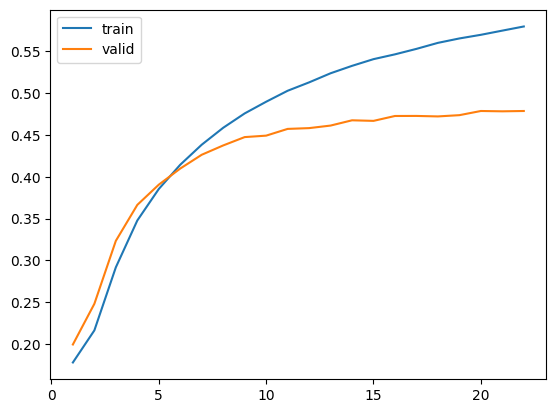

In [184]:
epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history1['val_accuracy'], label='valid')
plt.show()

In [187]:
def translate_sentence(input_text,
                       model,
                       input_tokenizer,
                       word2idx_outputs,
                       idx2word_target,
                       max_input_len,
                       max_output_len,
                       device):

    model.eval()
    PAD = word2idx_outputs['<pad>'] if '<pad>' in word2idx_outputs else 0

    # 1) Tokenizar y paddear la frase origen
    seq = input_tokenizer.texts_to_sequences([input_text.lower()])[0]
    seq = pad_sequences([seq], maxlen=max_input_len, padding='post', value=PAD)

    # -> Tensor [1, T_enc]
    enc_in = torch.tensor(seq, dtype=torch.long, device=device)

    # 2) Longitud real (sin PAD) y paso por el encoder
    enc_len = enc_in.ne(PAD).sum(dim=1)      # [1]
    prev_state = model.encoder(enc_in, enc_len)   # (h, c)

    # 3) Primer input del decoder = <sos>
    sos = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    dec_in = torch.tensor([[sos]], dtype=torch.long, device=device)  # [1,1]

    output_words = []

    # 4) Decodificación paso a paso (sin teacher forcing)
    with torch.no_grad():
        for _ in range(max_output_len):
            logits, prev_state = model.decoder(dec_in, prev_state)   # logits:[1,1,V]
            idx = logits.squeeze(1).argmax(dim=1).item()             # int

            if idx == eos:
                break
            output_words.append(idx2word_target[idx])

            # re-alimentar la predicción al decoder
            dec_in = torch.tensor([[idx]], dtype=torch.long, device=device)

    return ' '.join(output_words)


In [227]:
# -------------------------------------------
# 1) Elegimos una frase de prueba
# -------------------------------------------
i = np.random.randint(len(input_sentences))
src_sentence = input_sentences[i]
print("Source:", src_sentence)

# -------------------------------------------
# 2) Inferencia (sin gradientes)
#    best_model = modelo con pesos óptimos
# -------------------------------------------
translation = translate_sentence(
    input_text       = src_sentence,
    model            = best_model,      # o 'model' si ya tienes ese objeto
    input_tokenizer  = input_tokenizer, # tokenizer del idioma de entrada
    word2idx_outputs = word2idx_outputs,# dict  {token: índice} del idioma destino
    idx2word_target  = idx2word_target, # dict/list {índice: token} inverso
    max_input_len    = max_input_len,   # longitud usada en training (p. ej. 40)
    max_output_len   = max_out_len,     # tope de pasos decoder (p. ej. 50)
    device           = device           # "cuda" o "cpu"
)

print("Translation:", translation)

Source: A cat can see in the dark.
Translation: tom no sabe qué hacer con mary


---------

#### Sin filtrar padding en crossEntropy

Epoch   1: Train L=0.3551 A=0.6856 | Val L=0.3604 A=0.6014
Epoch   2: Train L=0.1161 A=0.7805 | Val L=0.3551 A=0.6053
Epoch   3: Train L=0.1155 A=0.7810 | Val L=0.3567 A=0.6036
Epoch   4: Train L=0.1145 A=0.7822 | Val L=0.3544 A=0.6036
Epoch   5: Train L=0.1145 A=0.7823 | Val L=0.3535 A=0.6028
Epoch   6: Train L=0.1127 A=0.7851 | Val L=0.3540 A=0.6047
Epoch   7: Train L=0.1128 A=0.7852 | Val L=0.3529 A=0.6057
Epoch   8: Train L=0.1118 A=0.7868 | Val L=0.3511 A=0.6012
Epoch   9: Train L=0.1116 A=0.7874 | Val L=0.3548 A=0.6035
Epoch  10: Train L=0.1105 A=0.7893 | Val L=0.3531 A=0.6052
Epoch  11: Train L=0.1105 A=0.7895 | Val L=0.3556 A=0.6020
Epoch  12: Train L=0.1096 A=0.7904 | Val L=0.3548 A=0.6020
Epoch  13: Train L=0.1090 A=0.7915 | Val L=0.3549 A=0.6028
Epoch  14: Train L=0.1084 A=0.7927 | Val L=0.3549 A=0.6055
Epoch  15: Train L=0.1076 A=0.7939 | Val L=0.3539 A=0.6045
Epoch  16: Train L=0.1074 A=0.7937 | Val L=0.3564 A=0.6048
Epoch  17: Train L=0.1071 A=0.7944 | Val L=0.3552 A=0.60

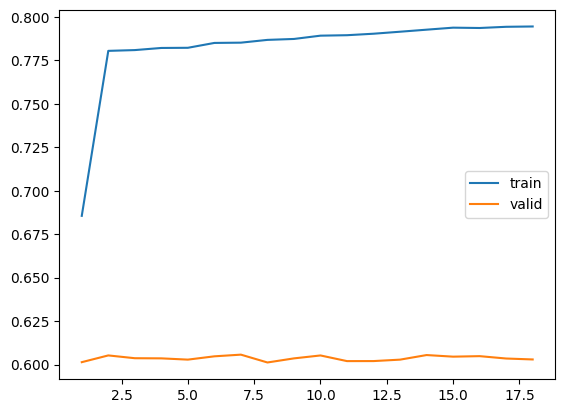

In [30]:
criterion = torch.nn.CrossEntropyLoss()
history, model = train(seq2seq,
                train_loader,
                valid_loader,
                optimizer,
                criterion,
                epochs=100,
                device=device,
                patience=10
                )
epoch_count = range(1, len(history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history['val_accuracy'], label='valid')
plt.show()

In [31]:
i = np.random.choice(len(input_sentences))
input_test = input_sentences[i:i+1][0]
translation = translate_sentence(
    input_text=input_test,
    model=model,
    input_tokenizer=input_tokenizer,
    word2idx_outputs=word2idx_outputs,
    idx2word_target=idx2word_target,
    max_input_len=max_input_len,
    max_output_len=max_out_len,   
    device=device
)

print("Input:   ", input_test)
print("Output:  ", translation)

Input:    If you ever do anything to hurt Tom, I'll kill you.
Output:   ¡eso es


---------------

In [32]:
class Encoder(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.lstm_size = 128
        self.num_layers = 2
        self.embedding_dim = embed_dim
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # marcar como layer no entrenable (freeze)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.1) # LSTM layer

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out)
        return (ht, ct)

class Decoder(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        self.lstm_size = 128
        self.num_layers = 2
        self.embedding_dim = embed_dim
        self.output_dim = output_dim

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.1) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=self.output_dim) # Fully connected layer

        # self.softmax = nn.Softmax(dim=1) # normalize in dim 1

    def forward(self, x, prev_state):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        # out = self.softmax(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        out = self.fc1(lstm_output)  # conserva la dimensión de secuencia
        # out = self.softmax(out.squeeze(1))  # quita dimensión de secuencia = 1
        return out, (ht, ct)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        assert encoder.lstm_size == decoder.lstm_size, "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.num_layers == decoder.num_layers, "Encoder and decoder must have equal number of layers!"
        
    def forward(self, encoder_input, decoder_input):
        batch_size = decoder_input.shape[0]
        decoder_input_len = decoder_input.shape[1]
        vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(batch_size, decoder_input_len, vocab_size, device=encoder_input.device)

        # ultimo hidden state del encoder, primer estado oculto del decoder
        prev_state = self.encoder(encoder_input)
        # En la primera iteracion se toma el primer token de target (<sos>)
        input = decoder_input[:, 0:1]

        for t in range(decoder_input_len):
            input = decoder_input[:, t:t+1]
            output, prev_state = self.decoder(input, prev_state)
            # top1 = output.argmax(1).view(-1, 1)
            top1 = output[:, -1, :].argmax(1).view(-1, 1)
            # guardar cada salida (softmax)
            outputs[:, t, :] = output.squeeze(1)
            # outputs[:, t, :] = output

        return outputs

In [33]:
encoder = Encoder(vocab_size=nb_words)
if cuda: encoder.cuda()
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.cuda()

seq2seq = Seq2Seq(encoder, decoder).to(device)
if cuda: seq2seq.cuda()

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=0.02)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)  # Omito el padding para que no falsee la metrica

x_enc = data_set[0:1][0]
x_dec = data_set[0:1][1]
summary(seq2seq,
        input_data=(x_enc.to(device).long(), x_dec.to(device).long()),
        device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Seq2Seq                                  [1, 50, 26342]            --
├─Encoder: 1-1                           [2, 1, 128]               --
│    └─Embedding: 2-1                    [1, 47, 300]              (4,057,500)
│    └─LSTM: 2-2                         [1, 47, 128]              352,256
├─Decoder: 1-2                           [1, 1, 26342]             --
│    └─Embedding: 2-3                    [1, 1, 300]               7,902,600
│    └─LSTM: 2-4                         [1, 1, 128]               352,256
│    └─Linear: 2-5                       [1, 1, 26342]             3,398,118
├─Decoder: 1-3                           [1, 1, 26342]             (recursive)
│    └─Embedding: 2-6                    [1, 1, 300]               (recursive)
│    └─LSTM: 2-7                         [1, 1, 128]               (recursive)
│    └─Linear: 2-8                       [1, 1, 26342]             (recursive)
├─Decoder: 1-4  

Epoch   1: Train L=5.6445 A=0.1988 | Val L=4.9476 A=0.2367
Epoch   2: Train L=4.6812 A=0.2495 | Val L=4.6413 A=0.2671
Epoch   3: Train L=4.3353 A=0.2767 | Val L=4.4763 A=0.2848
Epoch   4: Train L=4.1547 A=0.2899 | Val L=4.4290 A=0.2920
Epoch   5: Train L=4.0412 A=0.2970 | Val L=4.3969 A=0.2960
Epoch   6: Train L=3.9515 A=0.3022 | Val L=4.3931 A=0.2980
Epoch   7: Train L=3.8757 A=0.3061 | Val L=4.3769 A=0.3010
Epoch   8: Train L=3.8047 A=0.3107 | Val L=4.3633 A=0.3059
Epoch   9: Train L=3.7749 A=0.3109 | Val L=4.3757 A=0.3064
Epoch  10: Train L=3.7184 A=0.3146 | Val L=4.3611 A=0.3108
Epoch  11: Train L=3.6712 A=0.3184 | Val L=4.3542 A=0.3145
Epoch  12: Train L=3.6471 A=0.3177 | Val L=4.3819 A=0.3102
Epoch  13: Train L=3.6241 A=0.3184 | Val L=4.4223 A=0.3076
Epoch  14: Train L=3.6045 A=0.3183 | Val L=4.4098 A=0.3114
Epoch  15: Train L=3.5648 A=0.3218 | Val L=4.4327 A=0.3119
Epoch  16: Train L=3.5336 A=0.3242 | Val L=4.4063 A=0.3161
Epoch  17: Train L=3.4998 A=0.3282 | Val L=4.4028 A=0.32

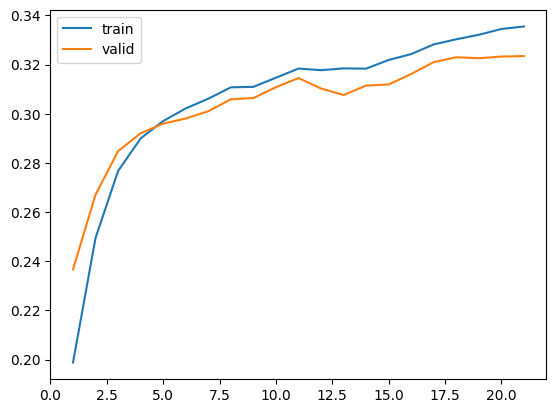

In [34]:
history, model = train(seq2seq,
                train_loader,
                valid_loader,
                optimizer,
                criterion,
                epochs=100,
                device=device,
                patience=10
                )
epoch_count = range(1, len(history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history['val_accuracy'], label='valid')
plt.show()

In [35]:
i = np.random.choice(len(input_sentences))
input_test = input_sentences[i:i+1][0]
translation = translate_sentence(
    input_text=input_test,
    model=model,
    input_tokenizer=input_tokenizer,
    word2idx_outputs=word2idx_outputs,
    idx2word_target=idx2word_target,
    max_input_len=max_input_len,
    max_output_len=max_out_len,   
    device=device
)

print("Input:   ", input_test)
print("Output:  ", translation)

Input:    Tom is sleeping, isn't he?
Output:   tom tiene un gato en la habitación y la mayoría de la ciudad en la pared


Epoch   1: Train L=0.7611 A=0.2860 | Val L=0.6488 A=0.3050
Epoch   2: Train L=0.5067 A=0.3230 | Val L=0.6371 A=0.3183
Epoch   3: Train L=0.4921 A=0.3314 | Val L=0.6334 A=0.3218
Epoch   4: Train L=0.4847 A=0.3359 | Val L=0.6334 A=0.3254
Epoch   5: Train L=0.4804 A=0.3386 | Val L=0.6330 A=0.3265
Epoch   6: Train L=0.4763 A=0.3422 | Val L=0.6316 A=0.3278
Epoch   7: Train L=0.4738 A=0.3444 | Val L=0.6324 A=0.3286
Epoch   8: Train L=0.4714 A=0.3460 | Val L=0.6299 A=0.3292
Epoch   9: Train L=0.4699 A=0.3474 | Val L=0.6325 A=0.3322
Epoch  10: Train L=0.4692 A=0.3484 | Val L=0.6303 A=0.3355
Epoch  11: Train L=0.4680 A=0.3491 | Val L=0.6311 A=0.3349
Epoch  12: Train L=0.4673 A=0.3498 | Val L=0.6331 A=0.3339
Epoch  13: Train L=0.4672 A=0.3498 | Val L=0.6351 A=0.3336
Epoch  14: Train L=0.4664 A=0.3505 | Val L=0.6343 A=0.3379
Epoch  15: Train L=0.4662 A=0.3506 | Val L=0.6369 A=0.3329
Epoch  16: Train L=0.4660 A=0.3510 | Val L=0.6344 A=0.3372
Epoch  17: Train L=0.4653 A=0.3515 | Val L=0.6338 A=0.33

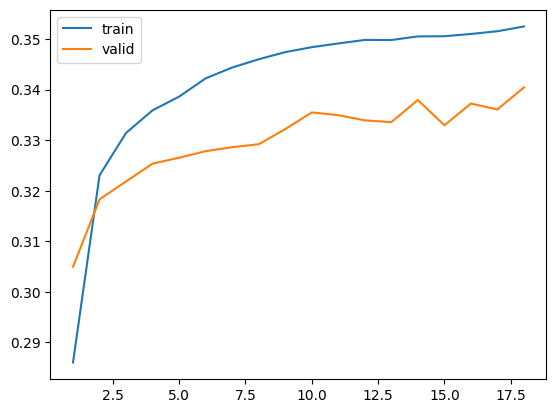

In [36]:
criterion = torch.nn.CrossEntropyLoss()
history, model = train(seq2seq,
                train_loader,
                valid_loader,
                optimizer,
                criterion,
                epochs=100,
                device=device,
                patience=10
                )
epoch_count = range(1, len(history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history['val_accuracy'], label='valid')
plt.show()

In [37]:
i = np.random.choice(len(input_sentences))
input_test = input_sentences[i:i+1][0]
translation = translate_sentence(
    input_text=input_test,
    model=model,
    input_tokenizer=input_tokenizer,
    word2idx_outputs=word2idx_outputs,
    idx2word_target=idx2word_target,
    max_input_len=max_input_len,
    max_output_len=max_out_len,   
    device=device
)

print("Input:   ", input_test)
print("Output:  ", translation)

Input:    You can never be too careful.
Output:   no te preocupes por la mañana pero no pude evitar reírme de que se le ocurrió un par de días


-----------

In [38]:
class Encoder(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.lstm_size = 256
        self.num_layers = 1
        self.embedding_dim = embed_dim
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # marcar como layer no entrenable (freeze)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.1) # LSTM layer

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out)
        return (ht, ct)

class Decoder(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        self.lstm_size = 256
        self.num_layers = 1
        self.embedding_dim = embed_dim
        self.output_dim = output_dim

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.1) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=self.output_dim) # Fully connected layer

        # self.softmax = nn.Softmax(dim=1) # normalize in dim 1

    def forward(self, x, prev_state):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        # out = self.softmax(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        out = self.fc1(lstm_output)  # conserva la dimensión de secuencia
        # out = self.softmax(out.squeeze(1))  # quita dimensión de secuencia = 1
        return out, (ht, ct)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        assert encoder.lstm_size == decoder.lstm_size, "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.num_layers == decoder.num_layers, "Encoder and decoder must have equal number of layers!"
        
    def forward(self, encoder_input, decoder_input):
        batch_size = decoder_input.shape[0]
        decoder_input_len = decoder_input.shape[1]
        vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(batch_size, decoder_input_len, vocab_size, device=encoder_input.device)

        # ultimo hidden state del encoder, primer estado oculto del decoder
        prev_state = self.encoder(encoder_input)
        # En la primera iteracion se toma el primer token de target (<sos>)
        input = decoder_input[:, 0:1]

        for t in range(decoder_input_len):
            input = decoder_input[:, t:t+1]
            output, prev_state = self.decoder(input, prev_state)
            # top1 = output.argmax(1).view(-1, 1)
            top1 = output[:, -1, :].argmax(1).view(-1, 1)
            # guardar cada salida (softmax)
            outputs[:, t, :] = output.squeeze(1)
            # outputs[:, t, :] = output

        return outputs

In [39]:
encoder = Encoder(vocab_size=nb_words)
if cuda: encoder.cuda()
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.cuda()

seq2seq = Seq2Seq(encoder, decoder).to(device)
if cuda: seq2seq.cuda()

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=0.02)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)  # Omito el padding para que no falsee la metrica

x_enc = data_set[0:1][0]
x_dec = data_set[0:1][1]
summary(seq2seq,
        input_data=(x_enc.to(device).long(), x_dec.to(device).long()),
        device=device)

c:\Users\Pablo\IA-repos\Desafios_NLP\venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Layer (type:depth-idx)                   Output Shape              Param #
Seq2Seq                                  [1, 50, 26342]            --
├─Encoder: 1-1                           [1, 1, 256]               --
│    └─Embedding: 2-1                    [1, 47, 300]              (4,057,500)
│    └─LSTM: 2-2                         [1, 47, 256]              571,392
├─Decoder: 1-2                           [1, 1, 26342]             --
│    └─Embedding: 2-3                    [1, 1, 300]               7,902,600
│    └─LSTM: 2-4                         [1, 1, 256]               571,392
│    └─Linear: 2-5                       [1, 1, 26342]             6,769,894
├─Decoder: 1-3                           [1, 1, 26342]             (recursive)
│    └─Embedding: 2-6                    [1, 1, 300]               (recursive)
│    └─LSTM: 2-7                         [1, 1, 256]               (recursive)
│    └─Linear: 2-8                       [1, 1, 26342]             (recursive)
├─Decoder: 1-4  

Epoch   1: Train L=4.6930 A=0.2846 | Val L=4.0752 A=0.3465
Epoch   2: Train L=3.5694 A=0.3745 | Val L=3.7928 A=0.3864
Epoch   3: Train L=3.1141 A=0.4086 | Val L=3.6884 A=0.3976
Epoch   4: Train L=2.8390 A=0.4338 | Val L=3.6506 A=0.4087
Epoch   5: Train L=2.6598 A=0.4519 | Val L=3.6593 A=0.4155
Epoch   6: Train L=2.5170 A=0.4681 | Val L=3.6787 A=0.4214
Epoch   7: Train L=2.4020 A=0.4819 | Val L=3.6801 A=0.4255
Epoch   8: Train L=2.2986 A=0.4952 | Val L=3.6973 A=0.4294
Epoch   9: Train L=2.2168 A=0.5065 | Val L=3.7207 A=0.4335
Epoch  10: Train L=2.1531 A=0.5166 | Val L=3.7549 A=0.4346
Epoch  11: Train L=2.4158 A=0.4774 | Val L=3.9691 A=0.4020
Epoch  12: Train L=2.3012 A=0.4870 | Val L=3.9174 A=0.4191
Epoch  13: Train L=2.1849 A=0.5063 | Val L=3.9347 A=0.4238
Epoch  14: Train L=2.1128 A=0.5188 | Val L=3.9544 A=0.4239
Early stopping triggered


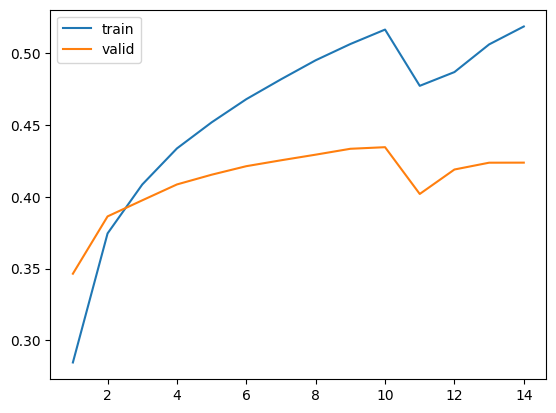

In [40]:
history, model = train(seq2seq,
                train_loader,
                valid_loader,
                optimizer,
                criterion,
                epochs=100,
                device=device,
                patience=10
                )
epoch_count = range(1, len(history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history['val_accuracy'], label='valid')
plt.show()

In [41]:
i = np.random.choice(len(input_sentences))
input_test = input_sentences[i:i+1][0]
translation = translate_sentence(
    input_text=input_test,
    model=model,
    input_tokenizer=input_tokenizer,
    word2idx_outputs=word2idx_outputs,
    idx2word_target=idx2word_target,
    max_input_len=max_input_len,
    max_output_len=max_out_len,   
    device=device
)

print("Input:   ", input_test)
print("Output:  ", translation)

Input:    What did you hear?
Output:   por lo hizo


Epoch   1: Train L=0.6531 A=0.4367 | Val L=0.5970 A=0.3971
Epoch   2: Train L=0.3113 A=0.5073 | Val L=0.5818 A=0.4107
Epoch   3: Train L=0.2927 A=0.5302 | Val L=0.5772 A=0.4163
Epoch   4: Train L=0.2839 A=0.5405 | Val L=0.5769 A=0.4194
Epoch   5: Train L=0.2787 A=0.5468 | Val L=0.5790 A=0.4197
Epoch   6: Train L=0.2753 A=0.5511 | Val L=0.5804 A=0.4206
Epoch   7: Train L=0.2734 A=0.5522 | Val L=0.5841 A=0.4195
Epoch   8: Train L=0.2721 A=0.5526 | Val L=0.5866 A=0.4222
Epoch   9: Train L=0.2723 A=0.5518 | Val L=0.5917 A=0.4205
Epoch  10: Train L=0.2731 A=0.5495 | Val L=0.5959 A=0.4207
Epoch  11: Train L=0.2760 A=0.5452 | Val L=0.6010 A=0.4173
Epoch  12: Train L=0.2806 A=0.5385 | Val L=0.6058 A=0.4176
Epoch  13: Train L=0.2859 A=0.5328 | Val L=0.6091 A=0.4146
Epoch  14: Train L=0.2893 A=0.5294 | Val L=0.6124 A=0.4160
Early stopping triggered


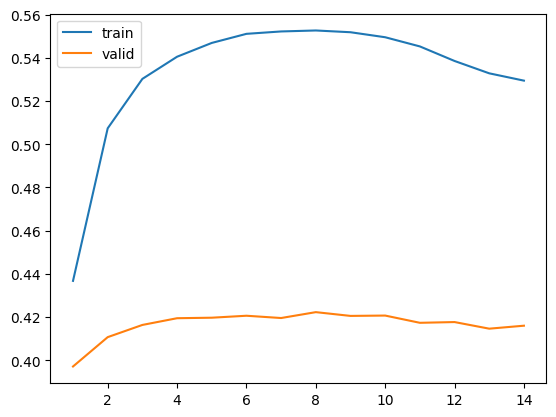

In [42]:
criterion = torch.nn.CrossEntropyLoss()
history, model = train(seq2seq,
                train_loader,
                valid_loader,
                optimizer,
                criterion,
                epochs=100,
                device=device,
                patience=10
                )
epoch_count = range(1, len(history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history['val_accuracy'], label='valid')
plt.show()

In [43]:
i = np.random.choice(len(input_sentences))
input_test = input_sentences[i:i+1][0]
translation = translate_sentence(
    input_text=input_test,
    model=model,
    input_tokenizer=input_tokenizer,
    word2idx_outputs=word2idx_outputs,
    idx2word_target=idx2word_target,
    max_input_len=max_input_len,
    max_output_len=max_out_len,   
    device=device
)

print("Input:   ", input_test)
print("Output:  ", translation)

Input:    Don't pretend what you don't feel.
Output:   sin dejar de disparar


In [53]:
i = np.random.choice(len(input_sentences))
input_test = input_sentences[i:i+1][0]
translation = translate_sentence(
    input_text=input_test,
    model=model,
    input_tokenizer=input_tokenizer,
    word2idx_outputs=word2idx_outputs,
    idx2word_target=idx2word_target,
    max_input_len=max_input_len,
    max_output_len=max_out_len,   
    device=device
)

print("Input:   ", input_test)
print("Output:  ", translation)

Input:    Mary is my older sister.
Output:   le advertiré a tom y mary


In [54]:
class Encoder(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.lstm_size = 128
        self.num_layers = 1
        self.embedding_dim = embed_dim
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # marcar como layer no entrenable (freeze)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers) # LSTM layer

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out)
        return (ht, ct)

class Decoder(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        self.lstm_size = 128
        self.num_layers = 1
        self.embedding_dim = embed_dim
        self.output_dim = output_dim

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=self.output_dim) # Fully connected layer

        # self.softmax = nn.Softmax(dim=1) # normalize in dim 1

    def forward(self, x, prev_state):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        # out = self.softmax(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        out = self.fc1(lstm_output)  # conserva la dimensión de secuencia
        # out = self.softmax(out.squeeze(1))  # quita dimensión de secuencia = 1
        return out, (ht, ct)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        assert encoder.lstm_size == decoder.lstm_size, "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.num_layers == decoder.num_layers, "Encoder and decoder must have equal number of layers!"
        
    def forward(self, encoder_input, decoder_input):
        batch_size = decoder_input.shape[0]
        decoder_input_len = decoder_input.shape[1]
        vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(batch_size, decoder_input_len, vocab_size, device=encoder_input.device)

        # ultimo hidden state del encoder, primer estado oculto del decoder
        prev_state = self.encoder(encoder_input)
        # En la primera iteracion se toma el primer token de target (<sos>)
        input = decoder_input[:, 0:1]

        for t in range(decoder_input_len):
            input = decoder_input[:, t:t+1]
            output, prev_state = self.decoder(input, prev_state)
            # top1 = output.argmax(1).view(-1, 1)
            top1 = output[:, -1, :].argmax(1).view(-1, 1)
            # guardar cada salida (softmax)
            outputs[:, t, :] = output.squeeze(1)
            # outputs[:, t, :] = output

        return outputs
    
encoder = Encoder(vocab_size=nb_words)
if cuda: encoder.cuda()
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.cuda()

seq2seq = Seq2Seq(encoder, decoder).to(device)
if cuda: seq2seq.cuda()

# Crear el optimizador la una función de error
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)  # Omito el padding para que no falsee la metrica

x_enc = data_set[0:1][0]
x_dec = data_set[0:1][1]
summary(seq2seq,
        input_data=(x_enc.to(device).long(), x_dec.to(device).long()),
        device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Seq2Seq                                  [1, 50, 26342]            --
├─Encoder: 1-1                           [1, 1, 128]               --
│    └─Embedding: 2-1                    [1, 47, 300]              (4,057,500)
│    └─LSTM: 2-2                         [1, 47, 128]              220,160
├─Decoder: 1-2                           [1, 1, 26342]             --
│    └─Embedding: 2-3                    [1, 1, 300]               7,902,600
│    └─LSTM: 2-4                         [1, 1, 128]               220,160
│    └─Linear: 2-5                       [1, 1, 26342]             3,398,118
├─Decoder: 1-3                           [1, 1, 26342]             (recursive)
│    └─Embedding: 2-6                    [1, 1, 300]               (recursive)
│    └─LSTM: 2-7                         [1, 1, 128]               (recursive)
│    └─Linear: 2-8                       [1, 1, 26342]             (recursive)
├─Decoder: 1-4  

Epoch   1: Train L=4.9857 A=0.2459 | Val L=4.3349 A=0.2964
Epoch   2: Train L=3.8511 A=0.3317 | Val L=3.9402 A=0.3486
Epoch   3: Train L=3.3377 A=0.3815 | Val L=3.7735 A=0.3750
Epoch   4: Train L=3.0093 A=0.4157 | Val L=3.6965 A=0.3927
Epoch   5: Train L=2.7678 A=0.4426 | Val L=3.6598 A=0.4022
Epoch   6: Train L=2.5819 A=0.4649 | Val L=3.6492 A=0.4096
Epoch   7: Train L=2.4372 A=0.4830 | Val L=3.6471 A=0.4168
Epoch   8: Train L=2.3123 A=0.4996 | Val L=3.6615 A=0.4202
Epoch   9: Train L=2.2108 A=0.5140 | Val L=3.6775 A=0.4244
Epoch  10: Train L=2.1256 A=0.5267 | Val L=3.6919 A=0.4269
Epoch  11: Train L=2.0514 A=0.5372 | Val L=3.7252 A=0.4265
Epoch  12: Train L=1.9912 A=0.5461 | Val L=3.7572 A=0.4291
Epoch  13: Train L=1.9367 A=0.5549 | Val L=3.7895 A=0.4298
Epoch  14: Train L=1.8915 A=0.5619 | Val L=3.8319 A=0.4350
Epoch  15: Train L=1.8523 A=0.5683 | Val L=3.8559 A=0.4295
Epoch  16: Train L=1.8117 A=0.5755 | Val L=3.8929 A=0.4338
Epoch  17: Train L=1.7805 A=0.5811 | Val L=3.9277 A=0.43

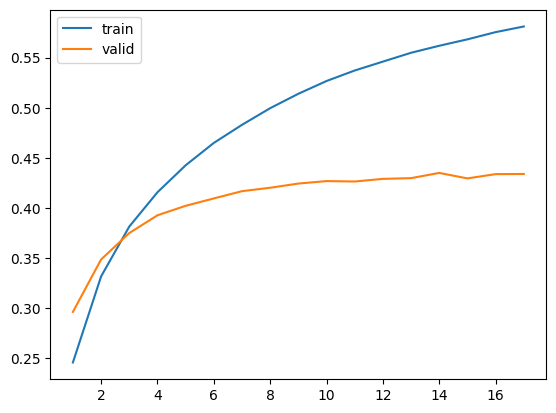

In [55]:
history, model = train(seq2seq,
                train_loader,
                valid_loader,
                optimizer,
                criterion,
                epochs=100,
                device=device,
                patience=10
                )
epoch_count = range(1, len(history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history['val_accuracy'], label='valid')
plt.show()

In [77]:
i = np.random.choice(len(input_sentences))
input_test = input_sentences[i:i+1][0]
translation = translate_sentence(
    input_text=input_test,
    model=model,
    input_tokenizer=input_tokenizer,
    word2idx_outputs=word2idx_outputs,
    idx2word_target=idx2word_target,
    max_input_len=max_input_len,
    max_output_len=max_out_len,   
    device=device
)

print("Input:   ", input_test)
print("Output:  ", translation)

Input:    Tom was here all day.
Output:   por favor baja


In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.lstm_size = 256
        self.num_layers = 2
        self.embedding_dim = embed_dim
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # marcar como layer no entrenable (freeze)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.2) # LSTM layer

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out)
        return (ht, ct)

class Decoder(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        self.lstm_size = 256
        self.num_layers = 2
        self.embedding_dim = embed_dim
        self.output_dim = output_dim

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix_es))
        self.embedding.weight.requires_grad = True  # Opcional: Freezar
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.2) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=self.output_dim) # Fully connected layer

        # self.softmax = nn.Softmax(dim=1) # normalize in dim 1

    def forward(self, x, prev_state):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        # out = self.softmax(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        out = self.fc1(lstm_output)  # conserva la dimensión de secuencia
        # out = self.softmax(out.squeeze(1))  # quita dimensión de secuencia = 1
        return out, (ht, ct)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        assert encoder.lstm_size == decoder.lstm_size, "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.num_layers == decoder.num_layers, "Encoder and decoder must have equal number of layers!"

    def forward(self, encoder_input, decoder_input, tf_ratio=1.0):
        B, L_dec = decoder_input.size()
        V = self.decoder.output_dim
        outputs = torch.zeros(B, L_dec, V, device=encoder_input.device)

        prev_state = self.encoder(encoder_input)

        inp = decoder_input[:, 0:1]      # <sos>
        for t in range(L_dec):
            logits, prev_state = self.decoder(inp, prev_state)  # [B,1,V]
            outputs[:, t, :] = logits.squeeze(1)

            teacher = decoder_input[:, t:t+1]     # palabra real t
            pred    = logits.argmax(-1).unsqueeze(1)  # palabra predicha

            use_teacher = torch.rand(1).item() < tf_ratio
            inp = teacher if use_teacher else pred
        return outputs

    
encoder = Encoder(vocab_size=nb_words)
if cuda: encoder.cuda()
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.cuda()

seq2seq = Seq2Seq(encoder, decoder).to(device)
if cuda: seq2seq.cuda()

# Crear el optimizador la una función de error
emb_params   = list(decoder.embedding.parameters())            # solo embedding ES
other_params = [p for n, p in seq2seq.named_parameters()
                if "decoder.embedding" not in n]               # resto de la red
lr = 0.02
optimizer = torch.optim.AdamW(
    [
        {"params": emb_params,   "lr": lr*0.05},   # LR pequeño para embedding
        {"params": other_params, "lr": lr},   # LR normal resto
    ],
    betas=(0.9, 0.98),
    weight_decay=1e-4)

criterion = torch.nn.CrossEntropyLoss(ignore_index=0)  # Omito el padding para que no falsee la metrica

x_enc = data_set[0:1][0]
x_dec = data_set[0:1][1]
summary(seq2seq,
        input_data=(x_enc.to(device).long(), x_dec.to(device).long()),
        device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Seq2Seq                                  [1, 50, 26342]            --
├─Encoder: 1-1                           [2, 1, 256]               --
│    └─Embedding: 2-1                    [1, 47, 300]              (4,057,500)
│    └─LSTM: 2-2                         [1, 47, 256]              1,097,728
├─Decoder: 1-2                           [1, 1, 26342]             --
│    └─Embedding: 2-3                    [1, 1, 300]               7,902,600
│    └─LSTM: 2-4                         [1, 1, 256]               1,097,728
│    └─Linear: 2-5                       [1, 1, 26342]             6,769,894
├─Decoder: 1-3                           [1, 1, 26342]             (recursive)
│    └─Embedding: 2-6                    [1, 1, 300]               (recursive)
│    └─LSTM: 2-7                         [1, 1, 256]               (recursive)
│    └─Linear: 2-8                       [1, 1, 26342]             (recursive)
├─Decoder: 1

Epoch   1: Train L=6.5673 A=0.1616 | Val L=6.4128 A=0.1643
Epoch   2: Train L=6.3184 A=0.1641 | Val L=6.3886 A=0.1649
Epoch   3: Train L=6.2313 A=0.1643 | Val L=6.3278 A=0.1653
Epoch   4: Train L=6.0144 A=0.1653 | Val L=6.0071 A=0.1656
Epoch   5: Train L=5.7394 A=0.1783 | Val L=5.7259 A=0.1878
Epoch   6: Train L=5.4386 A=0.1958 | Val L=5.4534 A=0.2068
Epoch   7: Train L=5.1002 A=0.2262 | Val L=5.1284 A=0.2492
Epoch   8: Train L=4.7025 A=0.2626 | Val L=4.8269 A=0.2796
Epoch   9: Train L=4.3112 A=0.2949 | Val L=4.5378 A=0.3113
Epoch  10: Train L=3.9217 A=0.3274 | Val L=4.2686 A=0.3421
Epoch  11: Train L=3.5840 A=0.3544 | Val L=4.0899 A=0.3624
Epoch  12: Train L=3.3068 A=0.3762 | Val L=4.0079 A=0.3779
Epoch  13: Train L=3.0778 A=0.3964 | Val L=3.9370 A=0.3855
Epoch  14: Train L=2.8858 A=0.4151 | Val L=3.9606 A=0.3908
Epoch  15: Train L=2.7378 A=0.4320 | Val L=3.9206 A=0.3990
Epoch  16: Train L=2.6158 A=0.4489 | Val L=3.9147 A=0.4066
Epoch  17: Train L=2.5176 A=0.4622 | Val L=3.9443 A=0.40

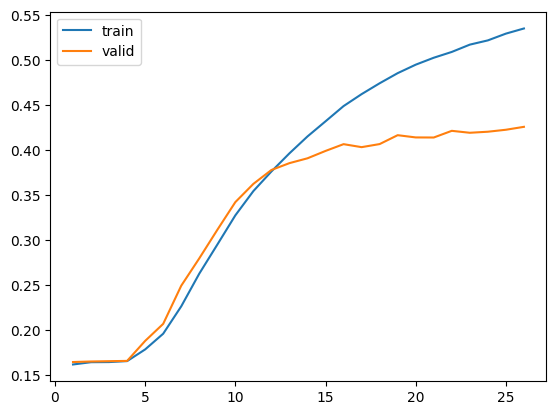

In [82]:
history, model = train(seq2seq,
                train_loader,
                valid_loader,
                optimizer,
                criterion,
                epochs=100,
                device=device,
                patience=10
                )
epoch_count = range(1, len(history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history['val_accuracy'], label='valid')
plt.show()

In [83]:
i = np.random.choice(len(input_sentences))
input_test = input_sentences[i:i+1][0]
translation = translate_sentence(
    input_text=input_test,
    model=model,
    input_tokenizer=input_tokenizer,
    word2idx_outputs=word2idx_outputs,
    idx2word_target=idx2word_target,
    max_input_len=max_input_len,
    max_output_len=max_out_len,   
    device=device
)

print("Input:   ", input_test)
print("Output:  ", translation)

Input:    She has plenty of work to do.
Output:   ella no tenido de experiencia haberte a a de de de de tu es mejor


---------

In [84]:
class Encoder(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.lstm_size = 128
        self.num_layers = 2
        self.embedding_dim = embed_dim
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # marcar como layer no entrenable (freeze)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.2) # LSTM layer

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out)
        return (ht, ct)

class Decoder(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        self.lstm_size = 128
        self.num_layers = 2
        self.embedding_dim = embed_dim
        self.output_dim = output_dim

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix_es))
        self.embedding.weight.requires_grad = True  # Opcional: Freezar
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.2) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=self.output_dim) # Fully connected layer
        self.ln_h  = nn.LayerNorm(self.lstm_size)

        # self.softmax = nn.Softmax(dim=1) # normalize in dim 1

    def forward(self, x, prev_state):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        # out = self.softmax(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        out = self.ln_h(lstm_output)
        out = self.fc1(out)  # conserva la dimensión de secuencia
        # out = self.softmax(out.squeeze(1))  # quita dimensión de secuencia = 1
        return out, (ht, ct)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        assert encoder.lstm_size == decoder.lstm_size, "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.num_layers == decoder.num_layers, "Encoder and decoder must have equal number of layers!"

    def forward(self, encoder_input, decoder_input, tf_ratio=1.0):
        B, L_dec = decoder_input.size()
        V = self.decoder.output_dim
        outputs = torch.zeros(B, L_dec, V, device=encoder_input.device)

        prev_state = self.encoder(encoder_input)

        inp = decoder_input[:, 0:1]      # <sos>
        for t in range(L_dec):
            logits, prev_state = self.decoder(inp, prev_state)  # [B,1,V]
            outputs[:, t, :] = logits.squeeze(1)

            teacher = decoder_input[:, t:t+1]     # palabra real t
            pred    = logits.argmax(-1).unsqueeze(1)  # palabra predicha

            use_teacher = torch.rand(1).item() < tf_ratio
            inp = teacher if use_teacher else pred
        return outputs

    
encoder = Encoder(vocab_size=nb_words)
if cuda: encoder.cuda()
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.cuda()

seq2seq = Seq2Seq(encoder, decoder).to(device)
if cuda: seq2seq.cuda()

# Crear el optimizador la una función de error
emb_params   = list(decoder.embedding.parameters())            # solo embedding ES
other_params = [p for n, p in seq2seq.named_parameters()
                if "decoder.embedding" not in n]               # resto de la red
lr = 0.02
optimizer = torch.optim.AdamW(
    [
        {"params": emb_params,   "lr": lr*0.1},   # LR pequeño para embedding
        {"params": other_params, "lr": lr},   # LR normal resto
    ],
    betas=(0.9, 0.98),
    weight_decay=1e-4)

criterion = torch.nn.CrossEntropyLoss(ignore_index=0)  # Omito el padding para que no falsee la metrica

x_enc = data_set[0:1][0]
x_dec = data_set[0:1][1]
summary(seq2seq,
        input_data=(x_enc.to(device).long(), x_dec.to(device).long()),
        device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Seq2Seq                                  [1, 50, 26342]            --
├─Encoder: 1-1                           [2, 1, 128]               --
│    └─Embedding: 2-1                    [1, 47, 300]              (4,057,500)
│    └─LSTM: 2-2                         [1, 47, 128]              352,256
├─Decoder: 1-2                           [1, 1, 26342]             --
│    └─Embedding: 2-3                    [1, 1, 300]               7,902,600
│    └─LSTM: 2-4                         [1, 1, 128]               352,256
│    └─LayerNorm: 2-5                    [1, 1, 128]               256
│    └─Linear: 2-6                       [1, 1, 26342]             3,398,118
├─Decoder: 1-3                           [1, 1, 26342]             (recursive)
│    └─Embedding: 2-7                    [1, 1, 300]               (recursive)
│    └─LSTM: 2-8                         [1, 1, 128]               (recursive)
│    └─LayerNorm: 2-9   

Epoch   1: Train L=5.5781 A=0.2137 | Val L=4.7950 A=0.2827
Epoch   2: Train L=4.3109 A=0.3168 | Val L=3.9791 A=0.3612
Epoch   3: Train L=3.6119 A=0.3793 | Val L=3.5864 A=0.4054
Epoch   4: Train L=3.1900 A=0.4208 | Val L=3.3593 A=0.4322
Epoch   5: Train L=2.9120 A=0.4506 | Val L=3.2370 A=0.4491
Epoch   6: Train L=2.7060 A=0.4727 | Val L=3.1900 A=0.4582
Epoch   7: Train L=2.5500 A=0.4901 | Val L=3.1377 A=0.4665
Epoch   8: Train L=2.4298 A=0.5042 | Val L=3.1268 A=0.4694
Epoch   9: Train L=2.3266 A=0.5156 | Val L=3.1032 A=0.4735
Epoch  10: Train L=2.2387 A=0.5263 | Val L=3.1250 A=0.4747
Epoch  11: Train L=2.1723 A=0.5349 | Val L=3.1003 A=0.4778
Epoch  12: Train L=2.1112 A=0.5425 | Val L=3.1189 A=0.4805
Epoch  13: Train L=2.0559 A=0.5501 | Val L=3.1475 A=0.4799
Epoch  14: Train L=2.0100 A=0.5563 | Val L=3.1323 A=0.4821
Epoch  15: Train L=1.9717 A=0.5623 | Val L=3.1550 A=0.4804
Epoch  16: Train L=1.9396 A=0.5662 | Val L=3.1516 A=0.4792
Epoch  17: Train L=1.9101 A=0.5713 | Val L=3.1800 A=0.48

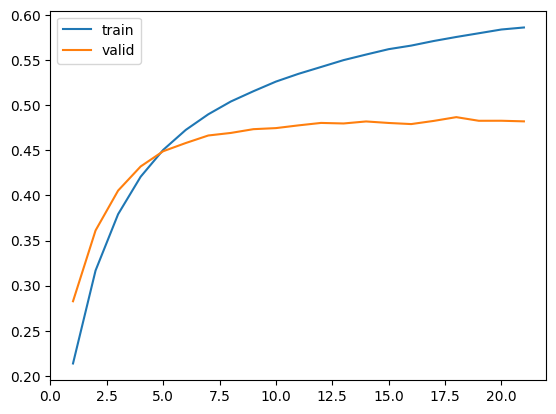

In [85]:
history, model = train(seq2seq,
                train_loader,
                valid_loader,
                optimizer,
                criterion,
                epochs=100,
                device=device,
                patience=10
                )
epoch_count = range(1, len(history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history['val_accuracy'], label='valid')
plt.show()

In [100]:
i = np.random.choice(len(input_sentences))
input_test = input_sentences[i:i+1][0]
translation = translate_sentence(
    input_text=input_test,
    model=model,
    input_tokenizer=input_tokenizer,
    word2idx_outputs=word2idx_outputs,
    idx2word_target=idx2word_target,
    max_input_len=max_input_len,
    max_output_len=max_out_len,   
    device=device
)

print("Input:   ", input_test)
print("Output:  ", translation)

Input:    He grew a beard to look more mature.
Output:   ¡felicidades


In [101]:
class Encoder(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.lstm_size = 256
        self.num_layers = 2
        self.embedding_dim = embed_dim
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # marcar como layer no entrenable (freeze)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.2) # LSTM layer

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out)
        return (ht, ct)

class Decoder(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        self.lstm_size = 256
        self.num_layers = 2
        self.embedding_dim = embed_dim
        self.output_dim = output_dim

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix_es))
        self.embedding.weight.requires_grad = True  # Opcional: Freezar
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers, dropout=0.2) # LSTM layer
        self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=self.output_dim) # Fully connected layer

        # self.softmax = nn.Softmax(dim=1) # normalize in dim 1

    def forward(self, x, prev_state):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out, prev_state)
        # out = self.softmax(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
        out = self.fc1(lstm_output)  # conserva la dimensión de secuencia
        # out = self.softmax(out.squeeze(1))  # quita dimensión de secuencia = 1
        return out, (ht, ct)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
        assert encoder.lstm_size == decoder.lstm_size, "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.num_layers == decoder.num_layers, "Encoder and decoder must have equal number of layers!"

    def forward(self, encoder_input, decoder_input, tf_ratio=1.0):
        B, L_dec = decoder_input.size()
        V = self.decoder.output_dim
        outputs = torch.zeros(B, L_dec, V, device=encoder_input.device)

        prev_state = self.encoder(encoder_input)

        inp = decoder_input[:, 0:1]      # <sos>
        for t in range(L_dec):
            logits, prev_state = self.decoder(inp, prev_state)  # [B,1,V]
            outputs[:, t, :] = logits.squeeze(1)

            teacher = decoder_input[:, t:t+1]     # palabra real t
            pred    = logits.argmax(-1).unsqueeze(1)  # palabra predicha

            use_teacher = torch.rand(1).item() < tf_ratio
            inp = teacher if use_teacher else pred
        return outputs

    
encoder = Encoder(vocab_size=nb_words)
if cuda: encoder.cuda()
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.cuda()

seq2seq = Seq2Seq(encoder, decoder).to(device)
if cuda: seq2seq.cuda()

# Crear el optimizador la una función de error
emb_params   = list(decoder.embedding.parameters())            # solo embedding ES
other_params = [p for n, p in seq2seq.named_parameters()
                if "decoder.embedding" not in n]               # resto de la red
lr = 0.02
optimizer = torch.optim.AdamW(
    [
        {"params": emb_params,   "lr": lr*0.05},   # LR pequeño para embedding
        {"params": other_params, "lr": lr},   # LR normal resto
    ],
    betas=(0.9, 0.98),
    weight_decay=1e-4)

criterion = torch.nn.CrossEntropyLoss(ignore_index=0)  # Omito el padding para que no falsee la metrica

x_enc = data_set[0:1][0]
x_dec = data_set[0:1][1]
summary(seq2seq,
        input_data=(x_enc.to(device).long(), x_dec.to(device).long()),
        device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Seq2Seq                                  [1, 50, 26342]            --
├─Encoder: 1-1                           [2, 1, 256]               --
│    └─Embedding: 2-1                    [1, 47, 300]              (4,057,500)
│    └─LSTM: 2-2                         [1, 47, 256]              1,097,728
├─Decoder: 1-2                           [1, 1, 26342]             --
│    └─Embedding: 2-3                    [1, 1, 300]               7,902,600
│    └─LSTM: 2-4                         [1, 1, 256]               1,097,728
│    └─Linear: 2-5                       [1, 1, 26342]             6,769,894
├─Decoder: 1-3                           [1, 1, 26342]             (recursive)
│    └─Embedding: 2-6                    [1, 1, 300]               (recursive)
│    └─LSTM: 2-7                         [1, 1, 256]               (recursive)
│    └─Linear: 2-8                       [1, 1, 26342]             (recursive)
├─Decoder: 1

Epoch   1: Train L=6.5599 A=0.1629 | Val L=6.4088 A=0.1618
Epoch   2: Train L=6.2778 A=0.1650 | Val L=6.2405 A=0.1654
Epoch   3: Train L=5.9267 A=0.1670 | Val L=6.0239 A=0.1678
Epoch   4: Train L=5.8189 A=0.1681 | Val L=5.9664 A=0.1675
Epoch   5: Train L=5.7444 A=0.1704 | Val L=5.9574 A=0.1698
Epoch   6: Train L=5.6957 A=0.1734 | Val L=5.9390 A=0.1748
Epoch   7: Train L=5.6546 A=0.1745 | Val L=5.9365 A=0.1739
Epoch   8: Train L=5.6254 A=0.1748 | Val L=5.8859 A=0.1749
Epoch   9: Train L=5.5708 A=0.1764 | Val L=5.8706 A=0.1747
Epoch  10: Train L=5.5160 A=0.1793 | Val L=5.8034 A=0.1797
Epoch  11: Train L=5.4526 A=0.1825 | Val L=5.7968 A=0.1820
Epoch  12: Train L=5.4206 A=0.1835 | Val L=5.7802 A=0.1852
Epoch  13: Train L=5.3778 A=0.1853 | Val L=5.7422 A=0.1880
Epoch  14: Train L=5.3464 A=0.1871 | Val L=5.7765 A=0.1857
Epoch  15: Train L=5.3533 A=0.1857 | Val L=5.7954 A=0.1828
Epoch  16: Train L=5.3004 A=0.1892 | Val L=5.6746 A=0.1914
Epoch  17: Train L=5.2213 A=0.1957 | Val L=5.6651 A=0.19

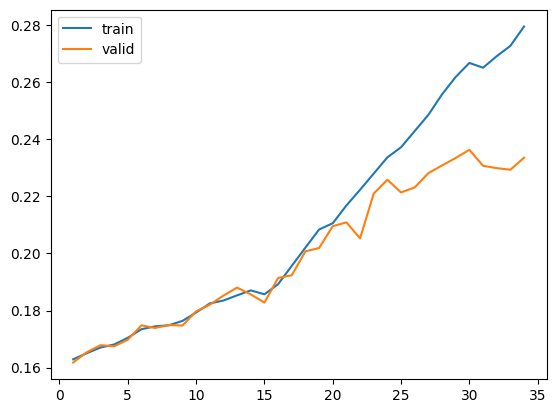

In [102]:
history, model = train(seq2seq,
                train_loader,
                valid_loader,
                optimizer,
                criterion,
                epochs=100,
                device=device,
                patience=10
                )
epoch_count = range(1, len(history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history['val_accuracy'], label='valid')
plt.show()

In [111]:
i = np.random.choice(len(input_sentences))
input_test = input_sentences[i:i+1][0]
translation = translate_sentence(
    input_text=input_test,
    model=model,
    input_tokenizer=input_tokenizer,
    word2idx_outputs=word2idx_outputs,
    idx2word_target=idx2word_target,
    max_input_len=max_input_len,
    max_output_len=max_out_len,   
    device=device
)

print("Input:   ", input_test)
print("Output:  ", translation)

Input:    It is obvious that that is a lie.
Output:   el es de educación en torneo el de pocos


In [124]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.lstm_size = 128
        self.num_layers = 2
        self.embedding_dim = embed_dim
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False  # marcar como layer no entrenable (freeze)
        self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
                            num_layers=self.num_layers)#, dropout=0.2) # LSTM layer

    def forward(self, x):
        out = self.embedding(x)
        lstm_output, (ht, ct) = self.lstm(out)
        return (ht, ct)

# class Decoder(nn.Module):
#     def __init__(self, vocab_size, output_dim):
#         super().__init__()
#         self.lstm_size = 128
#         self.num_layers = 2
#         self.embedding_dim = embed_dim
#         self.output_dim = output_dim

#         self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim, padding_idx=0)
#         self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix_es))
#         self.embedding.weight.requires_grad = True  # Opcional: Freezar
#         self.lstm = nn.LSTM(input_size=self.embedding_dim, hidden_size=self.lstm_size, batch_first=True,
#                             num_layers=self.num_layers)#, dropout=0.2) # LSTM layer
#         self.fc1 = nn.Linear(in_features=self.lstm_size, out_features=self.output_dim) # Fully connected layer

#         # self.softmax = nn.Softmax(dim=1) # normalize in dim 1

#     def forward(self, x, prev_state):
#         out = self.embedding(x)
#         lstm_output, (ht, ct) = self.lstm(out, prev_state)
#         # out = self.softmax(self.fc1(lstm_output[:,-1,:])) # take last output (last seq)
#         out = self.fc1(lstm_output)  # conserva la dimensión de secuencia
#         # out = self.softmax(out.squeeze(1))  # quita dimensión de secuencia = 1
#         return out, (ht, ct)

class Decoder(nn.Module):
    def __init__(self, vocab_size, output_dim):
        super().__init__()
        self.lstm_size     = 128
        self.num_layers    = 2
        self.embedding_dim = embed_dim
        self.output_dim    = output_dim

        # Embedding (español) — fine-tuneable
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=self.embedding_dim,
            padding_idx=0
        )
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix_es))
        self.embedding.weight.requires_grad = True

        # LSTM recibirá [embedding_dim + lstm_size] como input_size
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim + self.lstm_size,
            hidden_size=self.lstm_size,
            batch_first=True,
            num_layers=self.num_layers
        )

        # fc1 proyecta [lstm_output ⊕ context] de tamaño 2*lstm_size → output_dim
        self.fc1 = nn.Linear(
            in_features=2 * self.lstm_size,
            out_features=self.output_dim
        )

    def forward(self, x, prev_state, encoder_outputs, mask=None):
        """
        x               : [B, 1]              token de entrada al decoder
        prev_state      : (ht, ct) cada uno [num_layers, B, lstm_size]
        encoder_outputs : [B, T_enc, lstm_size]
        mask            : [B, T_enc] opcional (0 en pads)
        """
        # 1) Embedding
        emb = self.embedding(x)                          # [B,1,embedding_dim]

        # 2) Dot-product attention scores
        ht = prev_state[0][-1]                           # [B, lstm_size]
        scores = torch.bmm(
            ht.unsqueeze(1),                            # [B, 1, lstm_size]
            encoder_outputs.transpose(1, 2)             # [B, lstm_size, T_enc]
        ) / math.sqrt(self.lstm_size)                   # [B,1,T_enc]
        if mask is not None:
            scores = scores.masked_fill(mask.unsqueeze(1) == 0, -1e9)

        attn_weights = torch.softmax(scores, dim=-1)     # [B,1,T_enc]

        # 3) Context vector
        context = torch.bmm(attn_weights, encoder_outputs)  # [B,1,lstm_size]

        # 4) LSTM step con [emb ⊕ context]
        lstm_input = torch.cat([emb, context], dim=2)   # [B,1, embedding_dim+lstm_size]
        lstm_output, (ht, ct) = self.lstm(lstm_input, prev_state)  # lstm_output: [B,1,lstm_size]

        # 5) Concatenar de nuevo y proyectar
        combined = torch.cat([lstm_output, context], dim=2)  # [B,1,2*lstm_size]
        out = self.fc1(combined)                             # [B,1,output_dim]

        return out, (ht, ct)

# class Seq2Seq(nn.Module):
#     def __init__(self, encoder, decoder):
#         super().__init__()
        
#         self.encoder = encoder
#         self.decoder = decoder
        
#         assert encoder.lstm_size == decoder.lstm_size, "Hidden dimensions of encoder and decoder must be equal!"
#         assert encoder.num_layers == decoder.num_layers, "Encoder and decoder must have equal number of layers!"

#     def forward(self, encoder_input, decoder_input, tf_ratio=1.0):
#         B, L_dec = decoder_input.size()
#         V = self.decoder.output_dim
#         outputs = torch.zeros(B, L_dec, V, device=encoder_input.device)

#         prev_state = self.encoder(encoder_input)

#         inp = decoder_input[:, 0:1]      # <sos>
#         for t in range(L_dec):
#             logits, prev_state = self.decoder(inp, prev_state)  # [B,1,V]
#             outputs[:, t, :] = logits.squeeze(1)

#             teacher = decoder_input[:, t:t+1]     # palabra real t
#             pred    = logits.argmax(-1).unsqueeze(1)  # palabra predicha

#             use_teacher = torch.rand(1).item() < tf_ratio
#             inp = teacher if use_teacher else pred
#         return outputs
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, pad_idx=0):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx

        assert encoder.lstm_size == decoder.lstm_size, \
            "Hidden dimensions must match!"
        assert encoder.num_layers == decoder.num_layers, \
            "Number of layers must match!"

    def forward(self, encoder_input, decoder_input, tf_ratio=1.0):
        B, L_dec = decoder_input.size()
        V = self.decoder.output_dim
        device = encoder_input.device

        # 1) encode → ahora devuelve (outputs, (ht,ct))
        enc_out, prev_state = self.encoder(encoder_input)  # enc_out: [B, T_enc, H]

        # 2) máscara para padding (opcional)
        mask = (encoder_input != self.pad_idx)             # [B, T_enc]

        # 3) reservar salida
        outputs = torch.zeros(B, L_dec, V, device=device)
        inp = decoder_input[:, :1]  # <sos>

        # 4) bucle de decoding
        for t in range(L_dec):
            # <-- aquí pasamos enc_out y mask al decoder! -->
            logits, prev_state = self.decoder(inp,
                                              prev_state,
                                              enc_out,
                                              mask)
            outputs[:, t, :] = logits.squeeze(1)

            # teacher forcing
            teacher = decoder_input[:, t:t+1]
            pred    = logits.argmax(-1)
            if torch.rand(1).item() < tf_ratio:
                inp = teacher
            else:
                inp = pred

        return outputs

    
encoder = Encoder(vocab_size=nb_words)
if cuda: encoder.cuda()
# decoder --> vocab_size == output_dim --> porque recibe y devuelve palabras en el mismo vocabulario
decoder = Decoder(vocab_size=num_words_output, output_dim=num_words_output)
if cuda: decoder.cuda()

seq2seq = Seq2Seq(encoder, decoder).to(device)
if cuda: seq2seq.cuda()

# Crear el optimizador la una función de error
emb_params   = list(decoder.embedding.parameters())            # solo embedding ES
other_params = [p for n, p in seq2seq.named_parameters()
                if "decoder.embedding" not in n]               # resto de la red
lr = 0.05
optimizer = torch.optim.AdamW(
    [
        {"params": emb_params,   "lr": lr*0.1},   # LR pequeño para embedding
        {"params": other_params, "lr": lr},   # LR normal resto
    ],
    betas=(0.9, 0.98),
    weight_decay=1e-4)

criterion = torch.nn.CrossEntropyLoss(ignore_index=0)  # Omito el padding para que no falsee la metrica

x_enc = data_set[0:1][0]
x_dec = data_set[0:1][1]
# summary(seq2seq,
#         input_data=(x_enc.to(device).long(), x_dec.to(device).long()),
#         device=device)
summary(
    seq2seq,
    input_size=[
        (1, encoder_input_size),   # batch=1, T_enc
        (1, decoder_input_size)    # batch=1, T_dec
    ],
    dtypes=[torch.long, torch.long],
    device=device,
    col_names=("input_size","output_size","num_params"),
    depth=3
)

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Encoder: 1, Embedding: 2, LSTM: 2, Embedding: 2]

In [131]:
def sequence_acc(y_pred_logits, y_true_idx, pad_idx=0):
    """
    y_pred_logits: [B, L, V]   (logits, no softmax)
    y_true_idx:    [B, L]      (índices)
    """
    # 1) transforma logits → predicción de índice
    y_hat = y_pred_logits.argmax(dim=-1)          # [B, L]
    # 2) máscara de posiciones reales (no padding)
    mask = (y_true_idx != pad_idx)               # [B, L]
    # 3) compara y cuenta
    correct = (y_hat == y_true_idx) & mask       # [B, L]
    # 4) ratio sobre tokens reales
    return correct.sum().float() / mask.sum().float()


def train(model, train_loader, valid_loader,
          optimizer, criterion,
          epochs=100, pad_idx=0,
          tf_start=1.0, tf_end=0.5,
          patience=5, min_delta=1e-4,
          device='cuda'):
    model = model.to(device)

    train_loss, train_acc = [], []
    valid_loss, valid_acc = [], []

    best_val_loss = float('inf')
    patience_ctr = 0
    best_state = None

    for epoch in range(1, epochs+1):
        # --- ajusta tf_ratio linealmente ---
        tf_ratio = max(tf_end,
                       tf_start - (tf_start - tf_end) * (epoch-1)/(epochs-1)
                      )

        # --- entrenamiento ---
        model.train()
        run_loss, run_acc = 0.0, 0.0

        for enc_in, dec_in, target in train_loader:
            enc_in  = enc_in.to(device).long()
            dec_in  = dec_in.to(device).long()
            # si target viene one-hot → convierte a índices
            if target.dim()==3:
                target_idx = target.argmax(-1).to(device)
            else:
                target_idx = target.to(device).long()

            optimizer.zero_grad()
            logits = model(enc_in, dec_in, tf_ratio)  # [B,L,V]

            B, L, V = logits.shape
            logits_flat = logits.view(-1, V)         # [B*L, V]
            target_flat = target_idx.view(-1)        # [B*L]

            loss = criterion(logits_flat, target_flat)
            loss.backward()
            optimizer.step()

            run_loss += loss.item()
            run_acc  += sequence_acc(logits, target_idx, pad_idx).item()

        avg_train_loss = run_loss / len(train_loader)
        avg_train_acc  = run_acc  / len(train_loader)
        train_loss.append(avg_train_loss)
        train_acc .append(avg_train_acc)

        # --- validación ---
        model.eval()
        val_loss, val_acc = 0.0, 0.0
        with torch.no_grad():
            for enc_in, dec_in, target in valid_loader:
                enc_in  = enc_in.to(device).long()
                dec_in  = dec_in.to(device).long()
                if target.dim()==3:
                    target_idx = target.argmax(-1).to(device)
                else:
                    target_idx = target.to(device).long()

                logits = model(enc_in, dec_in, tf_ratio)
                B, L, V = logits.shape
                logits_flat = logits.view(-1, V)
                target_flat = target_idx.view(-1)

                loss = criterion(logits_flat, target_flat)
                val_loss += loss.item()
                val_acc  += sequence_acc(logits, target_idx, pad_idx).item()

        avg_val_loss = val_loss / len(valid_loader)
        avg_val_acc  = val_acc  / len(valid_loader)
        valid_loss.append(avg_val_loss)
        valid_acc .append(avg_val_acc)

        print(f"Epoch {epoch:3d}/{epochs} "
              f"tf={tf_ratio:.2f}  "
              f"Train L={avg_train_loss:.4f} A={avg_train_acc:.4f} | "
              f"Val L={avg_val_loss:.4f} A={avg_val_acc:.4f}")

        # early stopping
        if avg_val_loss + min_delta < best_val_loss:
            best_val_loss = avg_val_loss
            patience_ctr = 0
            best_state   = model.state_dict()
        else:
            patience_ctr += 1
            if patience_ctr >= patience:
                print(f"\nEarly stopping at epoch {epoch}")
                break

    # restaura mejor peso
    if best_state is not None:
        model.load_state_dict(best_state)

    history = {
        "loss": train_loss,
        "accuracy": train_acc,
        "val_loss": valid_loss,
        "val_accuracy": valid_acc,
    }
    return history, model


In [132]:
history, model = train(seq2seq,
                train_loader,
                valid_loader,
                optimizer,
                criterion,
                epochs=100,
                device=device,
                patience=8
                )
epoch_count = range(1, len(history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=history['val_accuracy'], label='valid')
plt.show()

Epoch   1/100 tf=1.00  Train L=10.1881 A=0.0000 | Val L=10.1880 A=0.0000


KeyboardInterrupt: 

In [127]:
i = np.random.choice(len(input_sentences))
input_test = input_sentences[i:i+1][0]
translation = translate_sentence(
    input_text=input_test,
    model=model,
    input_tokenizer=input_tokenizer,
    word2idx_outputs=word2idx_outputs,
    idx2word_target=idx2word_target,
    max_input_len=max_input_len,
    max_output_len=max_out_len,   
    device=device
)

print("Input:   ", input_test)
print("Output:  ", translation)

TypeError: Decoder.forward() missing 1 required positional argument: 'encoder_outputs'

-----------------

# Notas

- Se probó con redes más chicas de una capa, dos y tres. 
- Ampliando el estado oculto, con y sin dropout. 
- Sin filtrar le token de padding en el crossEntropy, el modelo daba mucho mejor accuracy, pero traducia muy mal. 
- Filtrando el padding, el accuracy da extremadamente bajo y sigue traduciendo igual de mal.